# <a name="top"></a>SWPLA PDDA 2020 Synthetic Sonic Log Generation Contest

**Author:** Ben Dowdell

**Date:** March XX, 2020

**Purpose:** To minimize RMSE in predicting Sonic logs (compressional & shear) from a suite of standard well logs

**v2 notebook goes with 'dowdell_submission_v2.csv'**

**Outline**

* [1. Initial Set-Up](#initial-setup)
** [1a. Standard Imports](#standard-imports)
** [1b. Sklearn Imports](#sklearn-imports)
** [1c. Helper Function Definitions](#helper-funcs)
* [2. Read Data](#read-data)
* [3. Inspect Data](#inspect-data)
* [4. EDA](#eda)
* [5. Baseline Model](#baseline)
* [6. Model Selection & Tuning](#model)
* [7. Blind Test QC, part 1](#blind-test-qc)
* [8. Ensemble stacking](#ensemble)
* [9. PCA for dimensionality reduction](#pca)
* [10. Final Predictions](#predictions)
* [11. Summary](#summary)

### Data Decription
#### Files
#### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


#### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

## <a name="initial-setup"></a>1. Initial Set-Up

Back to [top](#top)

### <a name="standard-imports"></a> 1a. Standard Imports

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from pprint import pprint
import time

random_state = 42
rng = np.random.RandomState(seed=42)

%matplotlib inline

In [2]:
plt.rcParams["axes.labelsize"] = 20

### <a name="sklearn-imports"></a>1b. Scikit-learn & Associated Imports

In [300]:
# Preprocessing utilities & Model Selection tools
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

# Feature Selection
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE, f_regression

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering Models
from sklearn.cluster import KMeans, DBSCAN

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import rfpimp as RFIMP

# Pipeline
from sklearn.pipeline import make_pipeline

# Several estimators we wish to use do not support MTR, so use MultiOutputRegressor
from sklearn.multioutput import MultiOutputRegressor

# XGBoost
import xgboost as xgb #for XGBRegressor

# Yellowbrick tools for model analysis
from yellowbrick.features import Rank1D, Rank2D
from yellowbrick.features import PCA as PCA_yb
from yellowbrick.target import FeatureCorrelation
from yellowbrick.model_selection import FeatureImportances, ValidationCurve

### Statsmodels imports

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

### <a name="helper-funcs"></a>1c. Helper Function Definitions

Helper function to plot data histograms

In [5]:
def plot_data_distributions(df):
    """Plot histograms of each curve
    
    Paramters:
    df (pandas.DataFrame) : Input data frame containing log curves
    
    Returns:
    matplotlib.figure.Figure
    """
    flag = 0
    n_subplots = len(df.columns.to_list())
    if n_subplots % 2 == 0:
        n_rows = 2
        n_cols = n_subplots // n_rows
    elif n_subplots % 3 == 0:
        n_rows = 3
        n_cols = n_subplots // n_rows
    else:
        n_cols = n_subplots // 2
        n_rows = n_subplots // n_cols
        n_rows += n_subplots % n_cols
        n_blank = (n_rows * n_cols) - n_subplots
        flag = 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,8))
    if flag == 1:
        axes[-1,-n_blank].axis('off')
    for ax, col in zip(axes.flatten(), df.columns.tolist()):
        ax.hist(df[col])
        if 'HR' in col:
            ax.set_xscale('log')
        ax.set_title('{} Histogram'.format(col))
    plt.tight_layout()
    return fig

Helper function to plot well curves in a normal log display

In [6]:
def plot_well_curves(data):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data (pandas.DataFrame) : Input data frame containing the well log curves, one per column
    
    curve_names (list) : A list containing the column name of each well log curve in the input data frame
    
    Returns:
    matplotlib.figure.Figure
    """
    # get the column names as a list
    curve_names = data.columns.tolist()
    
    # create the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data[curve], data.index, color='k')
        else:
            ax.plot(data[curve], data.index, color='k')
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS'] or 'DT' in curve:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
    ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to remove outliers from log curves using standard deviation from median value in a window

In [7]:
def filter_curves(data, window, n_std):
    """
    Takes a data frame containing well log curves and filters outliers based on n-standard deviations
    from a median filtered version of the data.
    
    Parameters:
    data (pandas.DataFrame) : The input data frame containing data to be filtered.  Each column is a well log curve.
    
    window (int) : The size of the window to use in creating a median filtered curve (recommend 33)
    
    n_std (int) : The number of +/- standard deviations to use in considering outliers (recommend 2)
    
    Returns:
    df_clean (pandas.DataFrame) : The filtered well curves
    df_outliers (pandas.DataFrame) : The outlier data points removed by the filtering operation
    """
    # create a copy of the original data
    df_copy = data.copy()
    
    # create a data frame containing median-filtered version of the data
    df_medfilter = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_medfilter[col] = df_copy[col].rolling(window, min_periods=1, center=True).median()
        
    # create a data frame containing standard deviation of the data
    df_stddev = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_stddev[col] = df_medfilter[col].rolling(window, min_periods=1, center=True).std()
        
    # create a data frame containing the cleaned version of the data using standard deviation from the median filtered data
    # and create a data frame containing the removed outliers
    df_clean = pd.DataFrame()
    df_outliers = pd.DataFrame()
    for col in df_copy.columns.tolist():
        upper = df_medfilter[col] + df_stddev[col]*n_std
        lower = df_medfilter[col] - df_stddev[col]*n_std
        df_clean[col] = df_copy[col].where((df_copy[col] <= upper) & (df_copy[col] >= lower))
        #df_clean[col] = df_clean[col].interpolate(limit_area='inside')
        df_outliers[col] = df_copy[col].where(df_clean[col] != df_copy[col])
    
    return df_clean, df_outliers

Helper function to remove outliers from log curves using [Interquartile Range:](https://datascience.stackexchange.com/a/57199)

```
Q1 = df['AVG'].quantile(0.25)
Q3 = df['AVG'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df['AVG'] >= Q1 - 1.5 * IQR) & (df['AVG'] <= Q3 + 1.5 *IQR)
df.loc[filter]
```

In [8]:
def iqr_filter(data):
    """
    Takes a data frame containing well log curves and filters outliers Interquartile Range (25 - 75%)
    
    Parameters:
    data (pandas.DataFrame) : The input data frame containing data to be filtered.  Each column is a well log curve.
    
    Returns:
    df_clean (pandas.DataFrame) : The filtered well curves
    df_outliers (pandas.DataFrame) : The outlier data points removed by the filtering operation
    """
    # create a copy of the original data
    df_copy = data.copy()
    
    # create a data frame containing the cleaned version of the data using IQR
    # and create a data frame containing removed outliers
    df_clean = pd.DataFrame(index=df_copy.index)
    df_outliers = pd.DataFrame(index=df_copy.index)
    for col in df_copy.columns.tolist():
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        iqr_filter = (df_copy[col] >= Q1 - 1.5 * IQR) & (df_copy[col] <= Q3 + 1.5 * IQR)
        df_clean[col] = df_copy[col].loc[iqr_filter]
        df_outliers[col] = df_copy[col].where(df_clean[col] != df_copy[col])
    
    return df_clean, df_outliers

Helper function to compare raw versus filtered logs

In [9]:
def qc_curve_filt(data_raw, data_cleaned, *args):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data_raw (pandas.DataFrame) : Input data frame containing the well log curves, one log per column
    
    data_cleaned (pandas.DataFrame) : Input data frame containing filtered log curves, one log per column
    
    *args (pandas.DataFrame) : Optional data frame containing outliers
    
    Returns:
    matplotlib.figure.Figure
    """
    
    # get the column names as a list, assumes col names are the same for each input data frame
    curve_names = data_raw.columns.tolist()
    
    # build the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.semilogx(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            for arg in args:
                ax.semilogx(arg[curve], arg.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        else:
            ax.plot(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.plot(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            for arg in args:
                ax.plot(arg[curve], arg.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS']:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to compare individual predictors to DTC & DTS

In [10]:
def compare_curves(predictor, dtc, dts):
    """
    Takes a predictor curve and plots it against both response variables, DTC & DTS
    
    Parameters:
    predictor (pandas.core.series.Series) : Independent Variable to compare, assumes either a column from a pandas DataFrame or ndarray-like
    
    dtc (pandas.core.series.Series) : DTC curve, assumes either a column from a pandas DataFrame or ndarray-like
    
    dts (pandas.core.series.Series) : DTS curve, assumes either a column from a pandas DataFrame or ndarray-like
    
    Returns:
    matplotlib.figure.Figure
    """
    fig = plt.figure(figsize=(20,10), linewidth=5, edgecolor='k')
    name = predictor.name
    fig.suptitle('{} curve comparison to DTC & DTS'.format(name), fontsize=20)
    
    ax1 = fig.add_subplot(2,2,1)
    if name == 'HRD':
        ax1.semilogy(predictor.index, predictor.values, 'k', lw=3)
    else:
        ax1.plot(predictor.index, predictor.values, 'k', lw=3)
    ax1c = ax1.twinx()
    ax1c.plot(dtc.index, dtc.values, 'r', lw=2)
    ax1c.invert_yaxis()
    ax1.set_ylabel(name)
    ax1c.set_ylabel('DTC', fontdict={'color':'r'})
    ax1.grid(False)
    ax1c.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 = sns.scatterplot(x=predictor, y=dtc)
    if name == 'HRD':
        ax2.set_xscale('log')
    ax2.set_xlabel(name)
    ax2.set_ylabel('DTC')
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    if name == 'HRD':
        ax3.semilogy(predictor.index, predictor.values, 'k', lw=3)
    else:
        ax3.plot(predictor.index, predictor.values, 'k', lw=3)
    ax3c = ax3.twinx()
    ax3c.plot(dts.index, dts.values, 'r', lw=2)
    ax3c.invert_yaxis()
    ax3.set_ylabel(name)
    ax3c.set_ylabel('DTS', fontdict={'color':'r'})
    ax3.grid(False)
    ax3c.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 = sns.scatterplot(x=predictor, y=dts)
    if name == 'HRD':
        ax4.set_xscale('log')
    ax4.set_xlabel(name)
    ax4.set_ylabel('DTS')
    ax4.grid(False)
    
    return fig

Helper function to plot Vp versus Vs using well known rock physics templates

In [11]:
def plot_vp_vs(x='DTC', y='DTS', color='index', df=None):
    """
    Plots measured Vp & Vs against well-known rock physics trends
    
    Parameters:
    x (pandas.Series) : Input DTC values, in us/ft
    y (pandas.Series) : Input DTS values, in us/ft
    color (str) : Input variable for coloring scatter plot, acceptable values are 'index' and df column names
    df (pandas.DataFrame) : Input data frame containing x & y
    
    Returns:
    matplotlib.figure.Figure
    """
    
    vp_ft_s = 1e6 / df[x]
    vp_m_s = vp_ft_s /  3.281
    vp_km_s = vp_m_s / 1000
    
    vs_ft_s = 1e6 / df[y]
    vs_m_s = vs_ft_s / 3.281
    vs_km_s = vs_m_s / 1000
    
    xvp = np.arange(start=0, stop=8, step=0.1)
    
    df_keys = df.columns.to_list()
    color_mapping = dict()
    color_mapping['index'] = df.index
    
    for key in df_keys:
        if key not in color_mapping:
            color_mapping[key] = df[key]
    
    Vs_castagna_ls = np.multiply(-0.05508, np.power(xvp, 2)) + np.multiply(1.0168, xvp) - 1.0305
    Vs_castagna_dm = np.multiply(0.5832, xvp) - 0.07776
    Vs_castagna_mudrock = np.multiply(0.8621, xvp) - 1.1724
    Vs_castagna_ss = np.multiply(0.8042, xvp) - 0.8559
    
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(Vs_castagna_ls, xvp, '--b', lw=2, label='Castagna et al. (1993) Water-saturated Limestone')
    ax.plot(Vs_castagna_dm, xvp, '--c', lw=2, label='Castagna et al. (1993) Water-saturated Dolomite')
    ax.plot(Vs_castagna_mudrock, xvp, '--k', lw=2, label='Castagna et al. (1993) Mudrock line')
    ax.plot(Vs_castagna_ss, xvp, '--r', lw=2, label='Castagna et al. (1993) Water-saturated sandstone')
    im = ax.scatter(vs_km_s, vp_km_s, s=10, c=color_mapping[color], marker='.', cmap='inferno', alpha=0.8)
    ax.set_xlabel('Vs (km/s)')
    ax.set_ylabel('Vp (km/s)')
    ax.set_title('Vp vs. Vs', fontsize=20, fontweight='bold')
    ax.set_xlim([np.nanmin(vs_km_s), np.nanmax(vs_km_s)])
    ax.set_ylim([np.nanmin(vp_km_s), np.nanmax(vp_km_s)])
    ax.legend(loc='upper left')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.invert_yaxis()
    cbar.set_label(f'{color}', fontdict={'fontweight':'bold'})
    
    return fig

Helper function to plot Training Real vs. Training Predicted

In [12]:
def plot_real_vs_pred(y, y_pred, feat_name, split):
    """Function that plots y vs y_pred
    
    Parameters:
    y (ndarray like) : real values
    y_pred (ndarray like) : predicted values
    feat_name (str) : Feature name
    split (str) : Whether this is 'Train', 'Test', or 'Full Log'
    
    returns matplotlib.figure.Figure
    """
    
    o2o = np.linspace(0, np.nanmax(y), len(y))
    
    fig = plt.figure(figsize=(20,6))
    fig.suptitle('Real {} vs. Predict'.format(split))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(y.reset_index(drop=True, inplace=False), 'k', lw=2, label='y {}'.format(split))
    ax1.plot(y_pred, 'r', lw=1, label='y_{}_pred'.format(split))
    ax1.set_xlabel('sample no.')
    ax1.set_ylabel(feat_name)
    ax1.set_title('{} Real & Predict'.format(split))
    ax1.legend(loc='best')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(y, y_pred, s=10, marker='.', alpha=0.8)
    ax2.plot(o2o, o2o, 'k', lw=2, label='one-to-one')
    ax2.set_xlabel('{} Real {}'.format(feat_name, split))
    ax2.set_ylabel('{} Predict {}'.format(feat_name, split))
    ax2.legend(loc='best')
    ax2.set_title('{} {} Predict vs. Real'.format(feat_name, split))
    
    return fig

Helper function to find consecutive NaN values and the starting index number
[Consecutive NaN larger than threshold](https://stackoverflow.com/questions46007776/consecutive-nan-larger-than-threshold-in-pandas-dataframe)

In [13]:
def consecutive_nans(index, col, threshold):
    """Function returns the starting index of consecutive NaN's in an input column
    Uses Divakar's answer in above link
    """
    
    thresh = threshold
    
    a = index.values
    b = col.values
    
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0, True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask = (count>=thresh) & np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_num = a[out_idx]
    out_count = count[valid_mask]
    out = range(int(out_num),int(out_num)+int(out_count)-1)
    
    return out

Helper function to plot custom [heatmap](https://github.com/amueller/mglearn/blob/master/mglearn/tools.py)

In [14]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

**Scorer functions for multi-output scoring**

We have multi-target output, so we need a custom scrorer.

r2 is the standard accuracy score.

rmse is the objective score to minimize

In [15]:
r2_scorer = make_scorer(r2_score, multioutput='uniform_average')
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, multioutput='uniform_average', squared=False)

Helper function for model evaluation

In [16]:
def model_eval(Estimator, X_train, y_train, preprocessing=None, scoring=None, cv=None, n_jobs=None):
    pipe = make_pipeline(preprocessing, Estimator)
    cvscore = cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=cv, n_jobs=n_jobs)
    print('{}-fold CV RMSE score for {} is {}:'.format(cv, Estimator.__class__.__name__, cvscore))
    print('Mean CV RMSE score for {} is {:.4f}'.format(Estimator.__class__.__name__, cvscore.mean()))
    pipe.fit(X_train, y_train)
    return pipe

## 2. <a name="read-data"></a>Read in Data

Back to [top](#top)

In [17]:
df_w1 = pd.read_csv('../data/train.csv')

In [18]:
df_w1.head()

CAL    CNC       GR    HRD    HRM     PE   ZDEN       DTC       DTS
0 -999.0 -999.0  41.4699 -999.0 -999.0 -999.0 -999.0  128.0737  319.0654
1 -999.0 -999.0  42.5053 -999.0 -999.0 -999.0 -999.0  127.8347  318.7825
2 -999.0 -999.0  43.1548 -999.0 -999.0 -999.0 -999.0  127.2307  317.3323
3 -999.0 -999.0  43.2410 -999.0 -999.0 -999.0 -999.0  126.2917  313.6486
4 -999.0 -999.0  40.3218 -999.0 -999.0 -999.0 -999.0  125.3985  307.8903

## 3. <a name="inspect-data"></a>Inspect Data

Back to [top](#top)

In [19]:
df_w1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
CAL     30143 non-null float64
CNC     30143 non-null float64
GR      30143 non-null float64
HRD     30143 non-null float64
HRM     30143 non-null float64
PE      30143 non-null float64
ZDEN    30143 non-null float64
DTC     30143 non-null float64
DTS     30143 non-null float64
dtypes: float64(9)
memory usage: 2.1 MB


All data are type float64

In [20]:
df_w1.describe().transpose()

count       mean         std    min        25%       50%        75%  \
CAL   30143.0  -8.394576  129.970219 -999.0    8.05835    8.6250    9.04885   
CNC   30143.0 -23.692615  157.142679 -999.0    0.12280    0.1936    0.33715   
GR    30143.0  38.959845  108.504554 -999.0   17.24875   36.8218   58.34615   
HRD   30143.0   3.977690  365.112753 -999.0    0.71770    1.6230    3.15830   
HRM   30143.0   1.547299  456.908969 -999.0    0.71205    1.6281    3.28060   
PE    30143.0 -17.446739  149.083136 -999.0    0.05310    4.9415    7.85665   
ZDEN  30143.0 -20.229982  148.809506 -999.0    2.22670    2.4322    2.55135   
DTC   30143.0 -54.891703  372.858812 -999.0   66.30435   78.3551  107.02250   
DTS   30143.0  -9.737567  440.314119 -999.0  118.53435  137.6893  182.97315   

             max  
CAL      21.0642  
CNC    3490.1582  
GR     1470.2534  
HRD   10000.0000  
HRM   60467.7617  
PE       28.1064  
ZDEN      3.2597  
DTC     155.9803  
DTS     487.4384

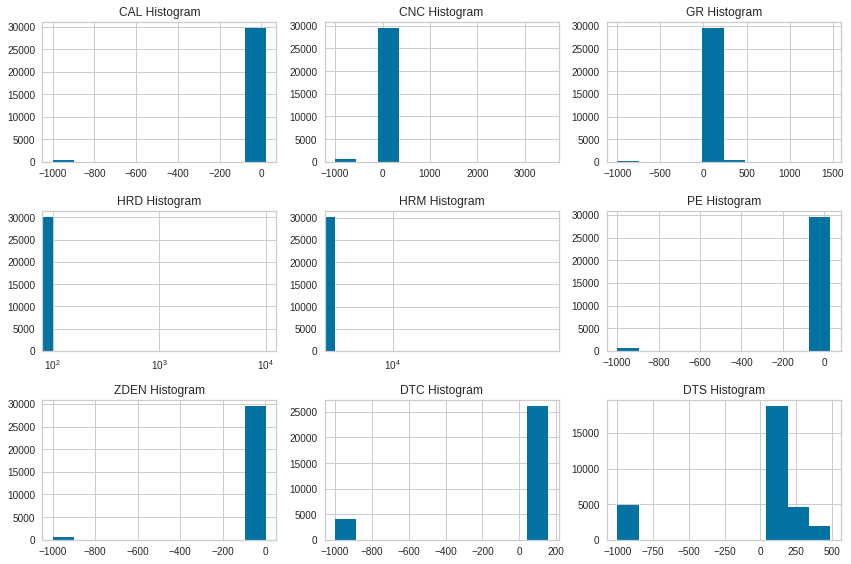

In [21]:
plot_data_distributions(df_w1.dropna())
plt.show()

Samples with value of -999.0 need to be replaced with NaN

In [22]:
df_w1.replace(to_replace=-999.0, value=np.nan, inplace=True)

In [23]:
df_w1.describe().transpose()

count        mean         std      min         25%        50%  \
CAL   29633.0    8.654281    1.749145   5.9304    8.135600    8.62500   
CNC   29408.0    0.683437   30.689679  -0.1028    0.127100    0.19850   
GR    29889.0   47.780541   51.377519  -0.1460   18.026100   37.08220   
HRD   29758.0   16.953912  349.067878   0.0541    0.740450    1.66275   
HRM   29758.0   14.492077  445.361622   0.0616    0.734700    1.66515   
PE    29464.0    5.173227    4.781088  -0.0232    0.054200    5.04250   
ZDEN  29462.0    2.393818    0.196276  -1.9238    2.234800    2.43960   
DTC   26089.0   91.814381   24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730   81.141960  80.5804  129.446625  144.59305   

             75%         max  
CAL     9.063000     21.0642  
CNC     0.343100   3490.1582  
GR     58.532800   1470.2534  
HRD     3.180350  10000.0000  
HRM     3.308900  60467.7617  
PE      7.949700     28.1064  
ZDEN    2.553000      3.2597  
DTC   112.112600    155.9803  
DTS   191.475125    487.4384

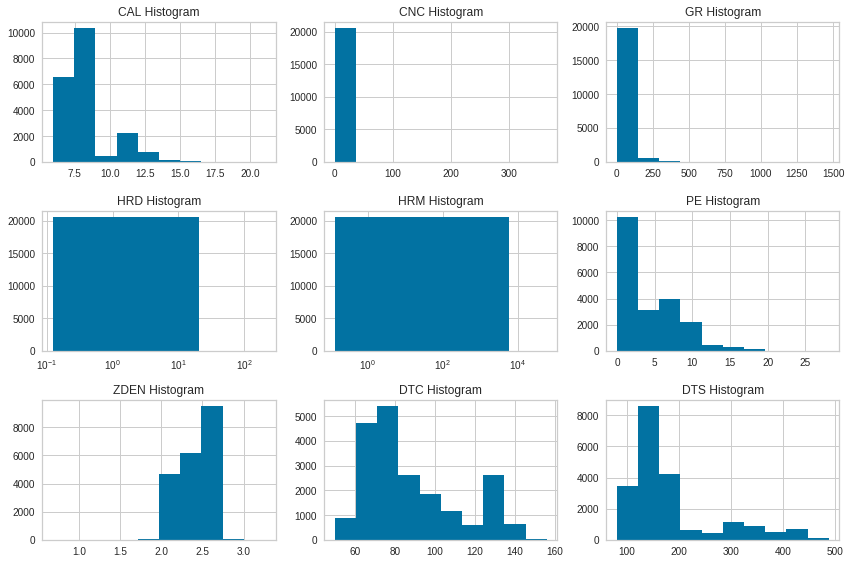

In [24]:
plot_data_distributions(df_w1.dropna())
plt.show()

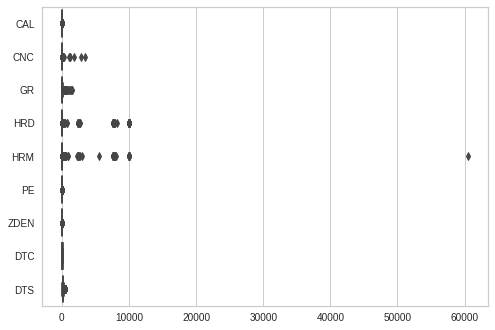

In [25]:
sns.boxplot(data=df_w1, orient='h')

There are some suspicious values here that we will explore in the next step, and lots of outliers according to the boxplot

1. CNC should range from 0.0 to 1.0
1. GR should not have values less than 0.0
1. PE should not have values less than 0.0
1. ZDEN should not have values less than 0.0

## <a name="eda"></a>4) Exploratory Data Analysis (EDA) & Cleaning

Back to [top](#top)

Before making any edits to values, plot the data for visual QC inspection

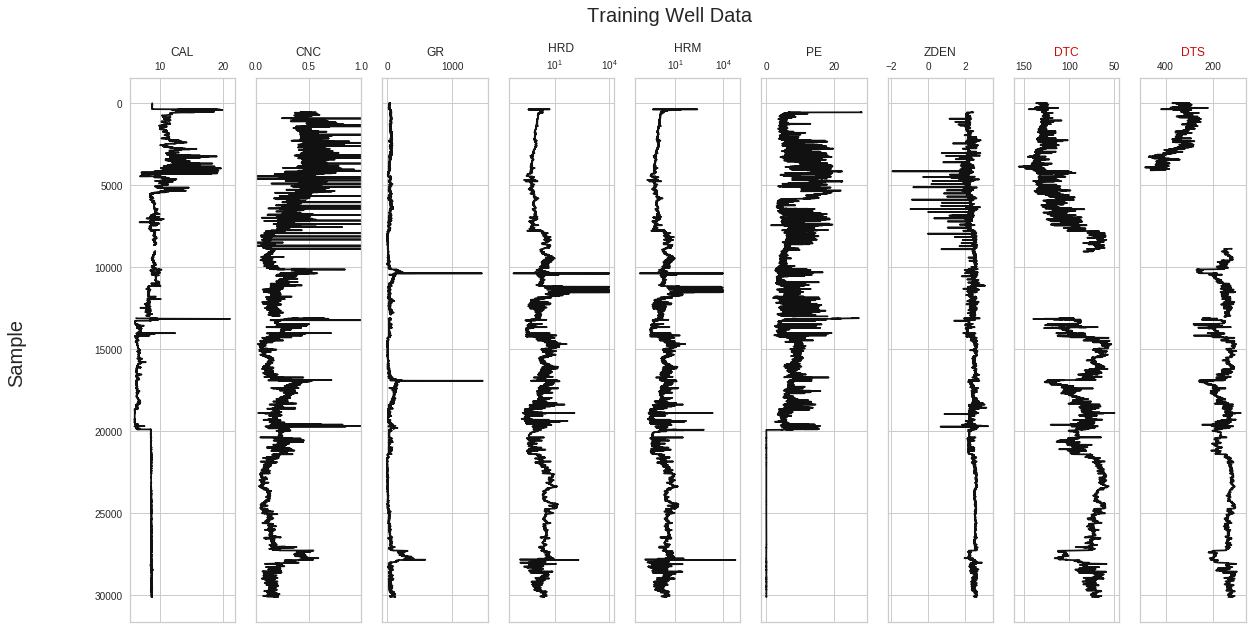

In [26]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

In [27]:
df_w1.describe().transpose()

count        mean         std      min         25%        50%  \
CAL   29633.0    8.654281    1.749145   5.9304    8.135600    8.62500   
CNC   29408.0    0.683437   30.689679  -0.1028    0.127100    0.19850   
GR    29889.0   47.780541   51.377519  -0.1460   18.026100   37.08220   
HRD   29758.0   16.953912  349.067878   0.0541    0.740450    1.66275   
HRM   29758.0   14.492077  445.361622   0.0616    0.734700    1.66515   
PE    29464.0    5.173227    4.781088  -0.0232    0.054200    5.04250   
ZDEN  29462.0    2.393818    0.196276  -1.9238    2.234800    2.43960   
DTC   26089.0   91.814381   24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730   81.141960  80.5804  129.446625  144.59305   

             75%         max  
CAL     9.063000     21.0642  
CNC     0.343100   3490.1582  
GR     58.532800   1470.2534  
HRD     3.180350  10000.0000  
HRM     3.308900  60467.7617  
PE      7.949700     28.1064  
ZDEN    2.553000      3.2597  
DTC   112.112600    155.9803  
DTS   191.475125    487.4384

Limit CNC to range between 0.0 and 1.0

In [28]:
df_w1.loc[df_w1['CNC'] < 0.0, ['CNC']] = np.nan
df_w1.loc[df_w1['CNC'] > 1.0, ['CNC']] = np.nan

Limit GR to range between 0.0 and 300.0

In [29]:
df_w1.loc[df_w1['GR'] < 0.0, ['GR']] = np.nan
df_w1.loc[df_w1['GR'] > 300.0, ['GR']] = np.nan

Limit PE to have values no less than 0.0

In [30]:
df_w1.loc[df_w1['PE'] < 0.0, ['PE']] = np.nan

Limit ZDEN to have values no less than 0.0

In [31]:
df_w1.loc[df_w1['ZDEN'] < 0.0, ['ZDEN']] = np.nan

In [32]:
df_w1.describe().transpose()

count        mean         std      min         25%        50%  \
CAL   29633.0    8.654281    1.749145   5.9304    8.135600    8.62500   
CNC   29308.0    0.247144    0.155301   0.0041    0.126800    0.19800   
GR    29685.0   45.468596   40.347602   0.0000   17.867400   36.87760   
HRD   29758.0   16.953912  349.067878   0.0541    0.740450    1.66275   
HRM   29758.0   14.492077  445.361622   0.0616    0.734700    1.66515   
PE    29455.0    5.174812    4.780959   0.0000    0.054200    5.04380   
ZDEN  29454.0    2.394661    0.189292   0.0035    2.234900    2.43970   
DTC   26089.0   91.814381   24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730   81.141960  80.5804  129.446625  144.59305   

             75%         max  
CAL     9.063000     21.0642  
CNC     0.340900      0.9997  
GR     58.015600    299.9370  
HRD     3.180350  10000.0000  
HRM     3.308900  60467.7617  
PE      7.950150     28.1064  
ZDEN    2.553100      3.2597  
DTC   112.112600    155.9803  
DTS   191.475125    487.4384

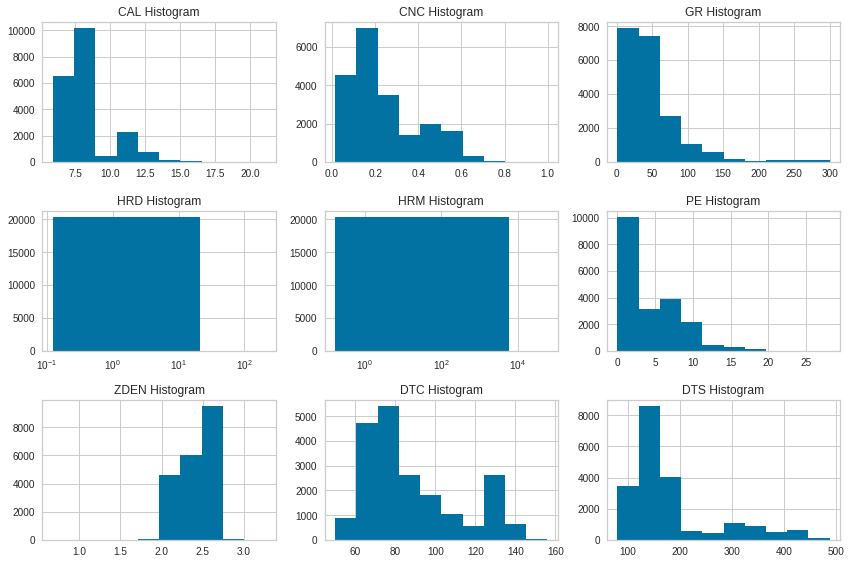

In [33]:
plot_data_distributions(df_w1.dropna())
plt.show()

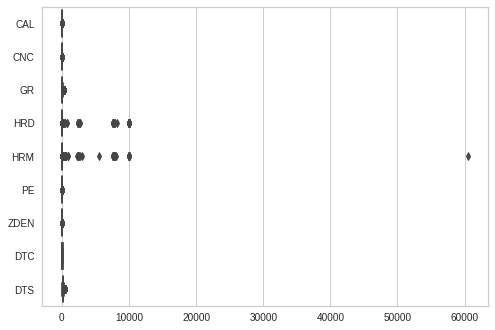

In [34]:
sns.boxplot(data=df_w1, orient='h')

These value ranges are substantially more acceptable.  HRD & HRM are on very different scales, and there are still outliers present, but less severe.

Most of the distributions actually appear to be log-normal.  Let's try applying a log transform and re-plot the distributions

Re-plot the data and visually inspect

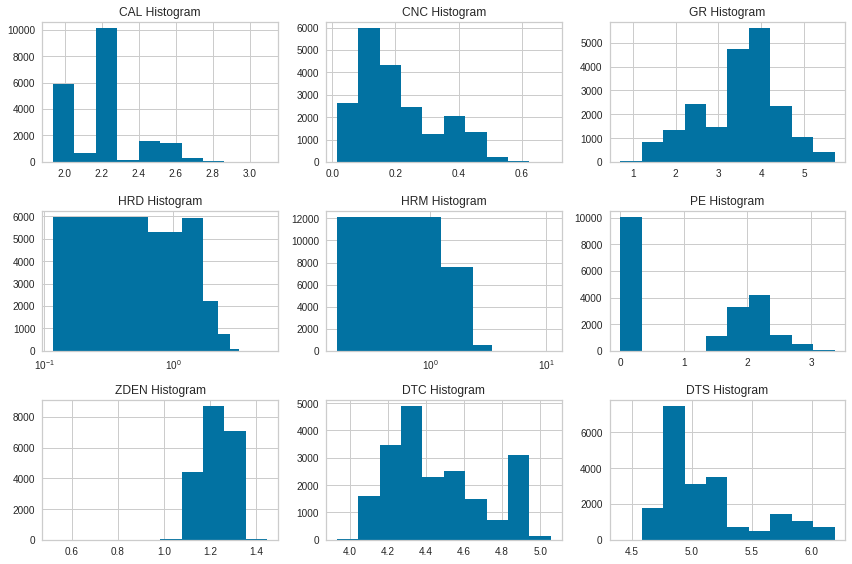

In [35]:
plot_data_distributions(df_w1.dropna().apply(lambda x: np.log(x+1)))
plt.show()

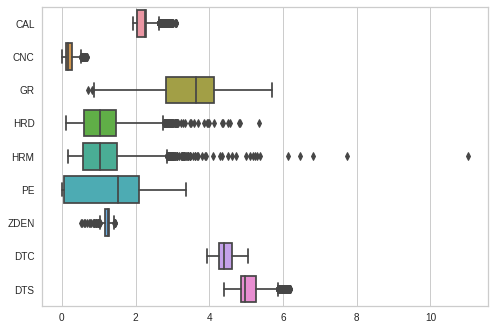

In [36]:
sns.boxplot(data=df_w1.dropna().apply(np.log1p), orient='h')

This suggests that most of the distributions tend to be log normal.  Applying the log transform as part of pre-processing could help improve model performance.

Additionally, we can use [Interquartile Range](https://en.wikipedia.org/wiki/Interquartile_range) to filter outliers.

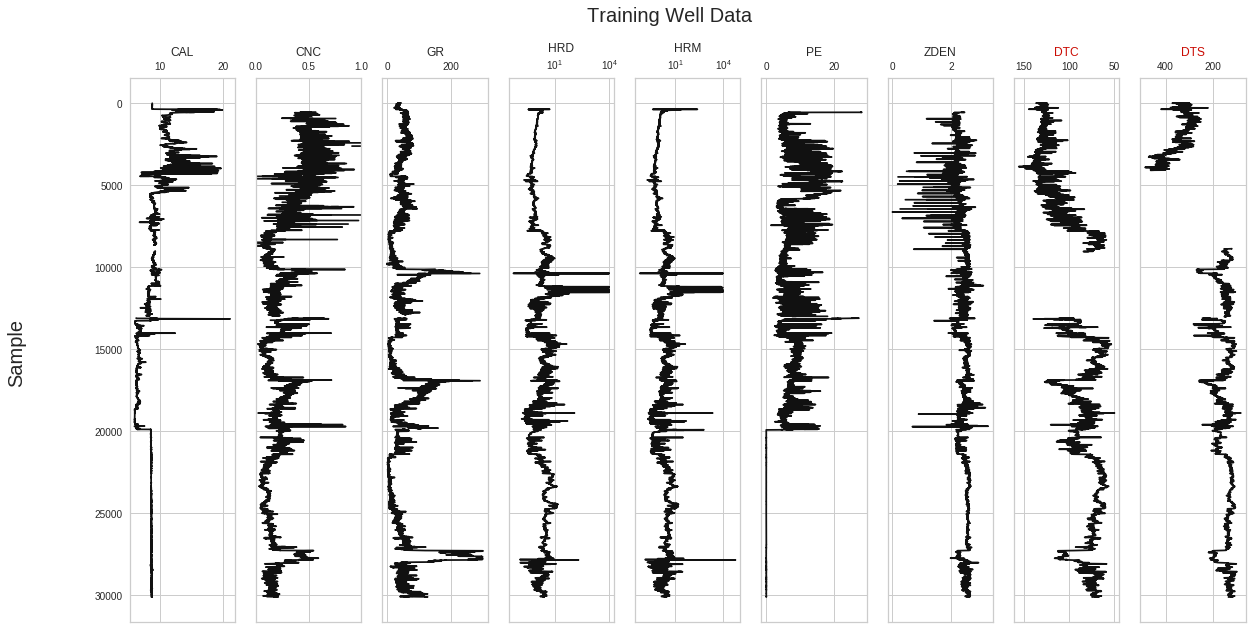

In [37]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

Overall, this appears to be better.  The PE final 10,000 values look suspect, though.

**Let's now remove the outliers**

We will use IQR to remove the outliers.

In [38]:
df_clean, df_outliers = iqr_filter(df_w1.apply(np.log1p))
df_clean = df_clean.apply(np.expm1)
df_outliers = df_outliers.apply(np.expm1)

In [39]:
# Pre-cleaned statistics
df_w1.describe().transpose()

count        mean         std      min         25%        50%  \
CAL   29633.0    8.654281    1.749145   5.9304    8.135600    8.62500   
CNC   29308.0    0.247144    0.155301   0.0041    0.126800    0.19800   
GR    29685.0   45.468596   40.347602   0.0000   17.867400   36.87760   
HRD   29758.0   16.953912  349.067878   0.0541    0.740450    1.66275   
HRM   29758.0   14.492077  445.361622   0.0616    0.734700    1.66515   
PE    29455.0    5.174812    4.780959   0.0000    0.054200    5.04380   
ZDEN  29454.0    2.394661    0.189292   0.0035    2.234900    2.43970   
DTC   26089.0   91.814381   24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730   81.141960  80.5804  129.446625  144.59305   

             75%         max  
CAL     9.063000     21.0642  
CNC     0.340900      0.9997  
GR     58.015600    299.9370  
HRD     3.180350  10000.0000  
HRM     3.308900  60467.7617  
PE      7.950150     28.1064  
ZDEN    2.553100      3.2597  
DTC   112.112600    155.9803  
DTS   191.475125    487.4384

In [40]:
# IQR cleaned statistics
df_clean.describe().transpose()

count        mean        std      min         25%        50%  \
CAL   19497.0    8.746848   0.512780   6.9024    8.578100    8.62500   
CNC   29242.0    0.245878   0.153139   0.0041    0.126700    0.19760   
GR    29597.0   45.599358  40.336069   2.4213   18.100300   36.97310   
HRD   29266.0    2.328212   2.275687   0.0541    0.729100    1.61085   
HRM   29334.0    2.401985   2.384355   0.0616    0.726625    1.62300   
PE    29455.0    5.174812   4.780959   0.0000    0.054200    5.04380   
ZDEN  29338.0    2.398611   0.175136   1.8139    2.236200    2.44090   
DTC   26089.0   91.814381  24.337910  49.9705   71.357000   85.23760   
DTS   23542.0  164.737865  57.367464  80.5804  128.056700  141.67965   

             75%       max  
CAL     8.849500   10.6331  
CNC     0.339275    0.7400  
GR     58.084100  299.9370  
HRD     3.086175   14.5584  
HRM     3.216450   15.8449  
PE      7.950150   28.1064  
ZDEN    2.553300    3.0785  
DTC   112.112600  155.9803  
DTS   182.340250  343.9744

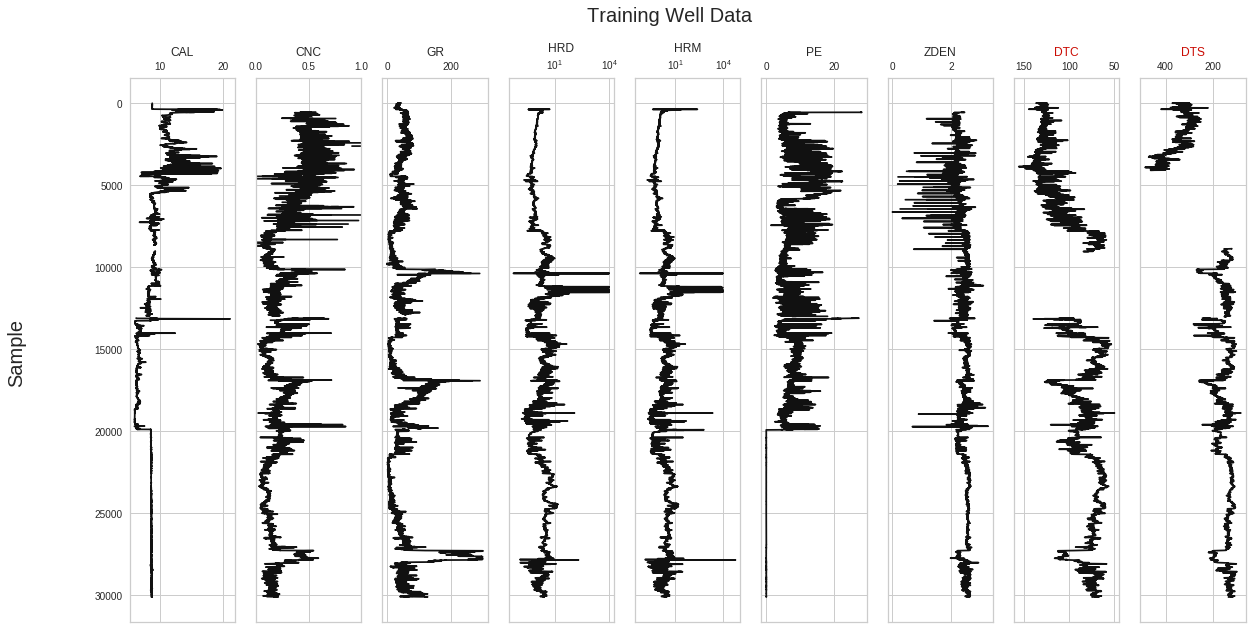

In [41]:
# pre-cleaned plot
plot_well_curves(df_w1)
plt.show()

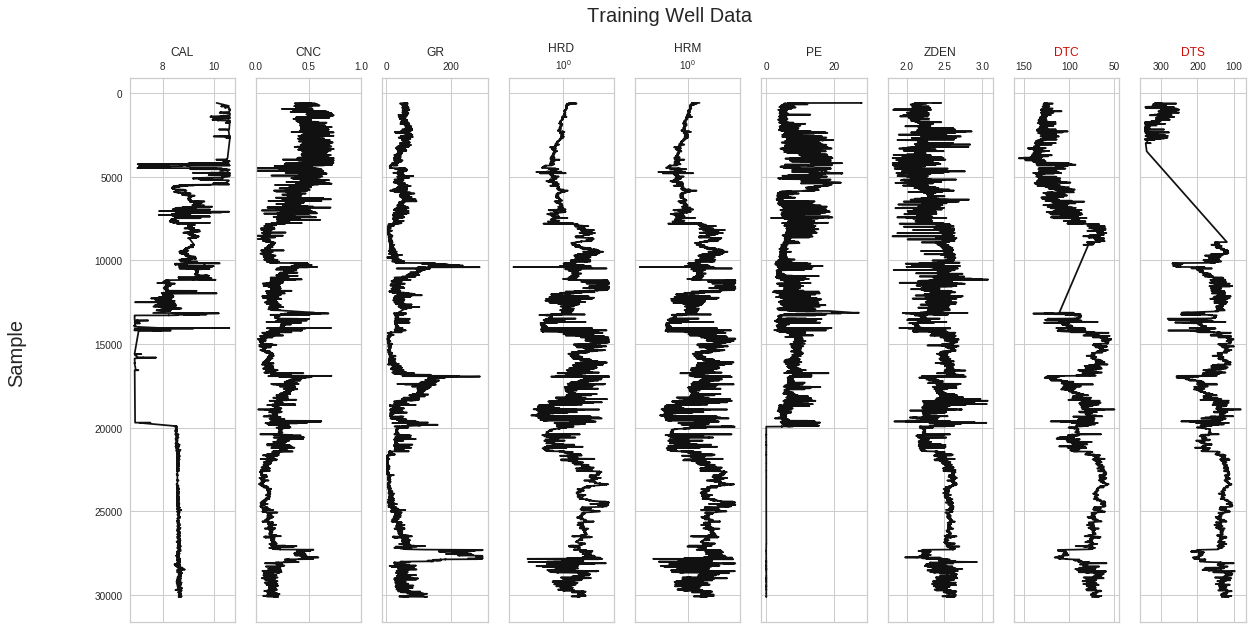

In [42]:
# IQR filtered plot
#cleaned_fig = plot_well_curves(df_clean)
cleaned_fig = plot_well_curves(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False)) # with gaps interpolated
plt.show()

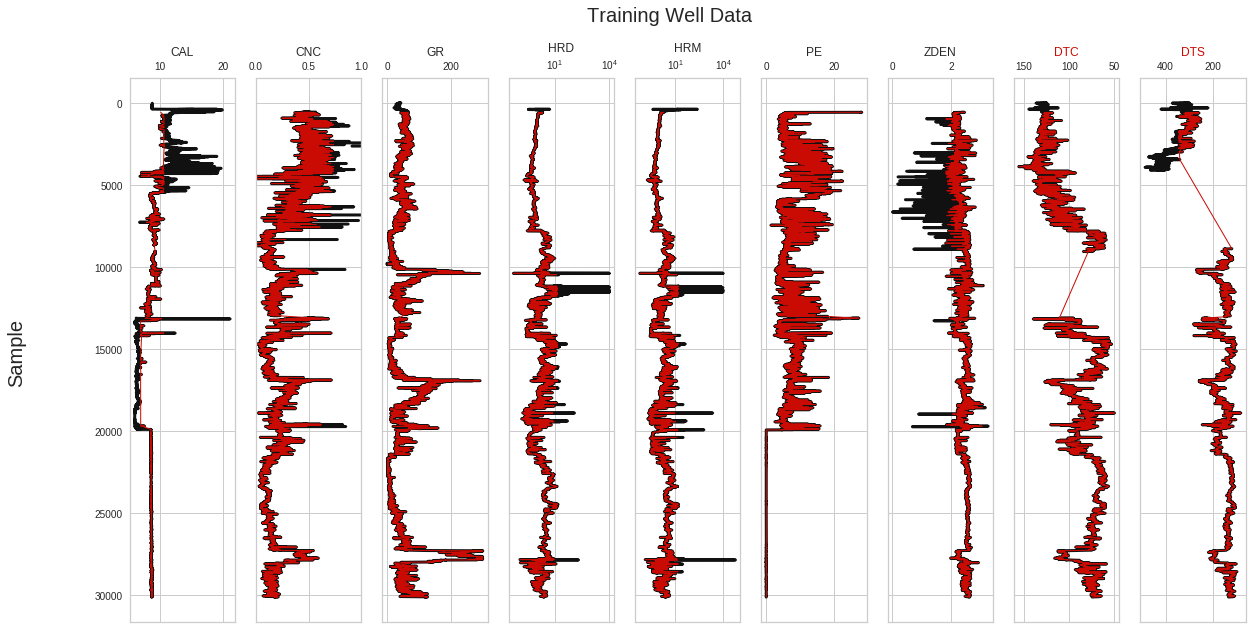

In [43]:
#qc_fig = qc_curve_filt(df_w1, df_clean)
qc_fig = qc_curve_filt(df_w1, df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
#qc_fig = qc_curve_filt(df_w1, df_clean, df_outliers)
plt.show()

Remove the bad values in PE

In [44]:
df_clean[df_clean['PE'] <= 1].head(1)

CAL     CNC       GR     HRD  HRM     PE    ZDEN      DTC       DTS
19939  8.5469  0.2689  41.2673  1.8264  NaN  0.049  2.1834  91.1456  185.8183

In [45]:
df_clean.loc[19939:,'PE'] = np.nan

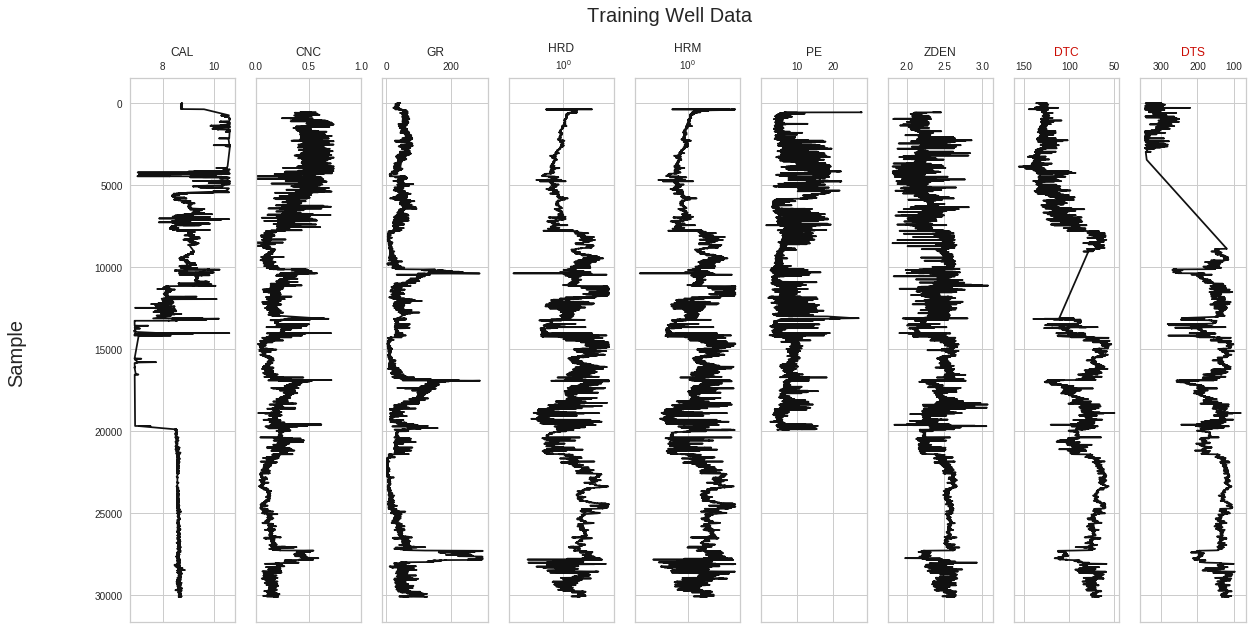

In [46]:
plot_well_curves(df_clean.interpolate(limit_area='inside'))
plt.show()

Overall, this seems like a successful method for removing outliers.  It does not perform very well for CAL, but CAL does not look like a very good curve to begin with.  The final 10,000 samples are suspect as the borehole width apparently increases.  This is unrealistic.  There is also some data which gets removed from DTS.  Overall, we may chose to use un-filtered versions of the target variables DTC & DTS.

Let's look at the boxplot again

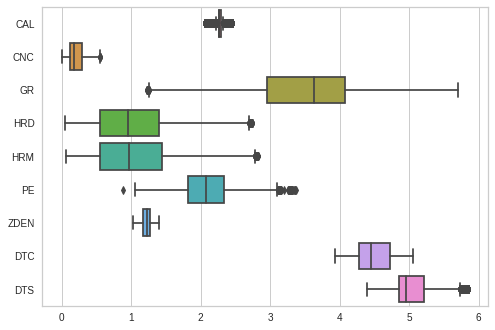

In [47]:
sns.boxplot(data=df_clean.apply(np.log1p), orient='h')

**At this point, it seems prudent to make some plots comparing our final cleaned curves to established rock property trends as a QC of the imputation and filtering**

Use plot_vp_vs to plot the imputed data against well known lithology trends, first the *pre-imputation* data ...

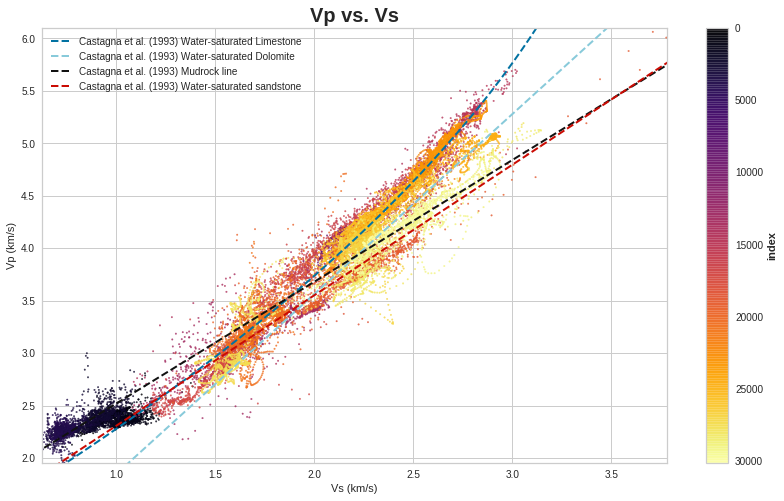

In [48]:
plot_vp_vs(x='DTC', y='DTS', df=df_w1)
plt.show()

**A few observations:**

1. Limestone appears to be a significant lithology.

1. Shale / Claystone also appear to be present throughout the well.

1. Sands are present.  Some sands may be difficult to discriminate in the overlap zone between Shale, Sand, & Limestone lines.  Gas-charged sands fall below the water-saturated sandstone line.

1. There may be a minor amount of dolomite present in the system.

1. Vp & Vs trends are obviously dependent upon lithology.  Plotting all of the data together, there is obvious heteroscedasticity.  Linear models would not fare well directly predicting Vs from Vp.  However, by using other features which are sensitive to lithologic variations, we should be able to build a robust model to handle these challenges.

**CAL seems a little suspect, though.  It seems unusual for CAL to increase at the bottom of the hole**

In fact, CAL and PE basically go bad at the same sample number, so it is likely they had a shared tool failure

There are several ways to proceed.

A few observations:

* CAL could be useful (variations in the wellbore are related to geomechanical properties), but it can also be rather stationary.
* If we want to maximize the amount of data available for estimating DTC & DTS, then interpolation is necessary.
* The last 10,000 samples in the PE curve appear to be bogus.  Maybe these can be estimated using the shallower section?
* HRM (Medium Resisitivity) should be dropped.  Without knowing the depth of investigation, it is likely to be contaminated with well-bore fluids.  HRD (Deep Resisitivity) is the better resistivity curve to use.  Maybe we could calculate Rt?

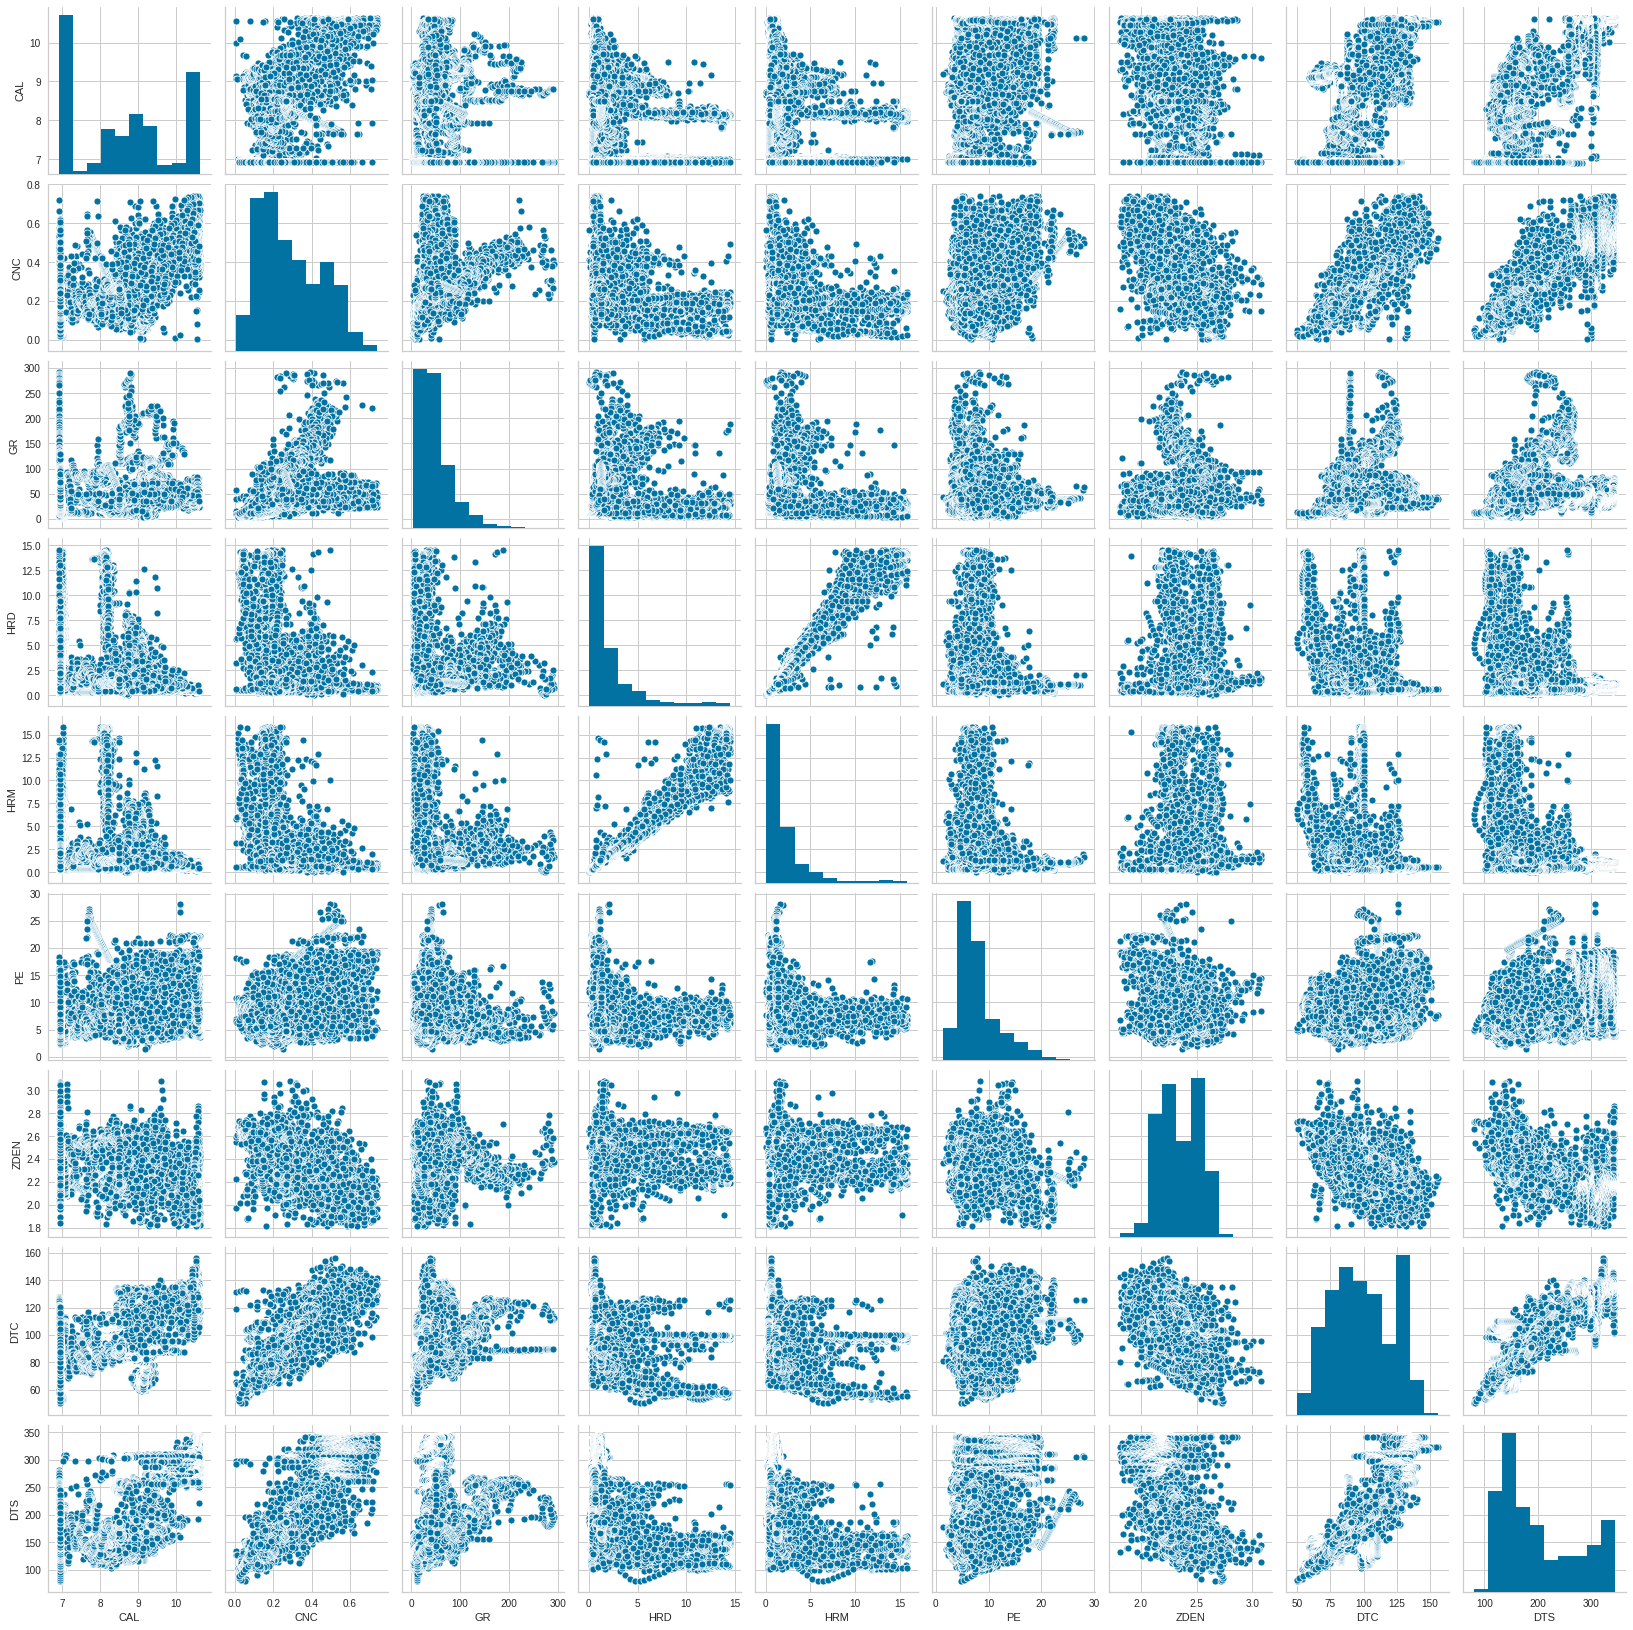

In [49]:
sns.pairplot(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
plt.show()

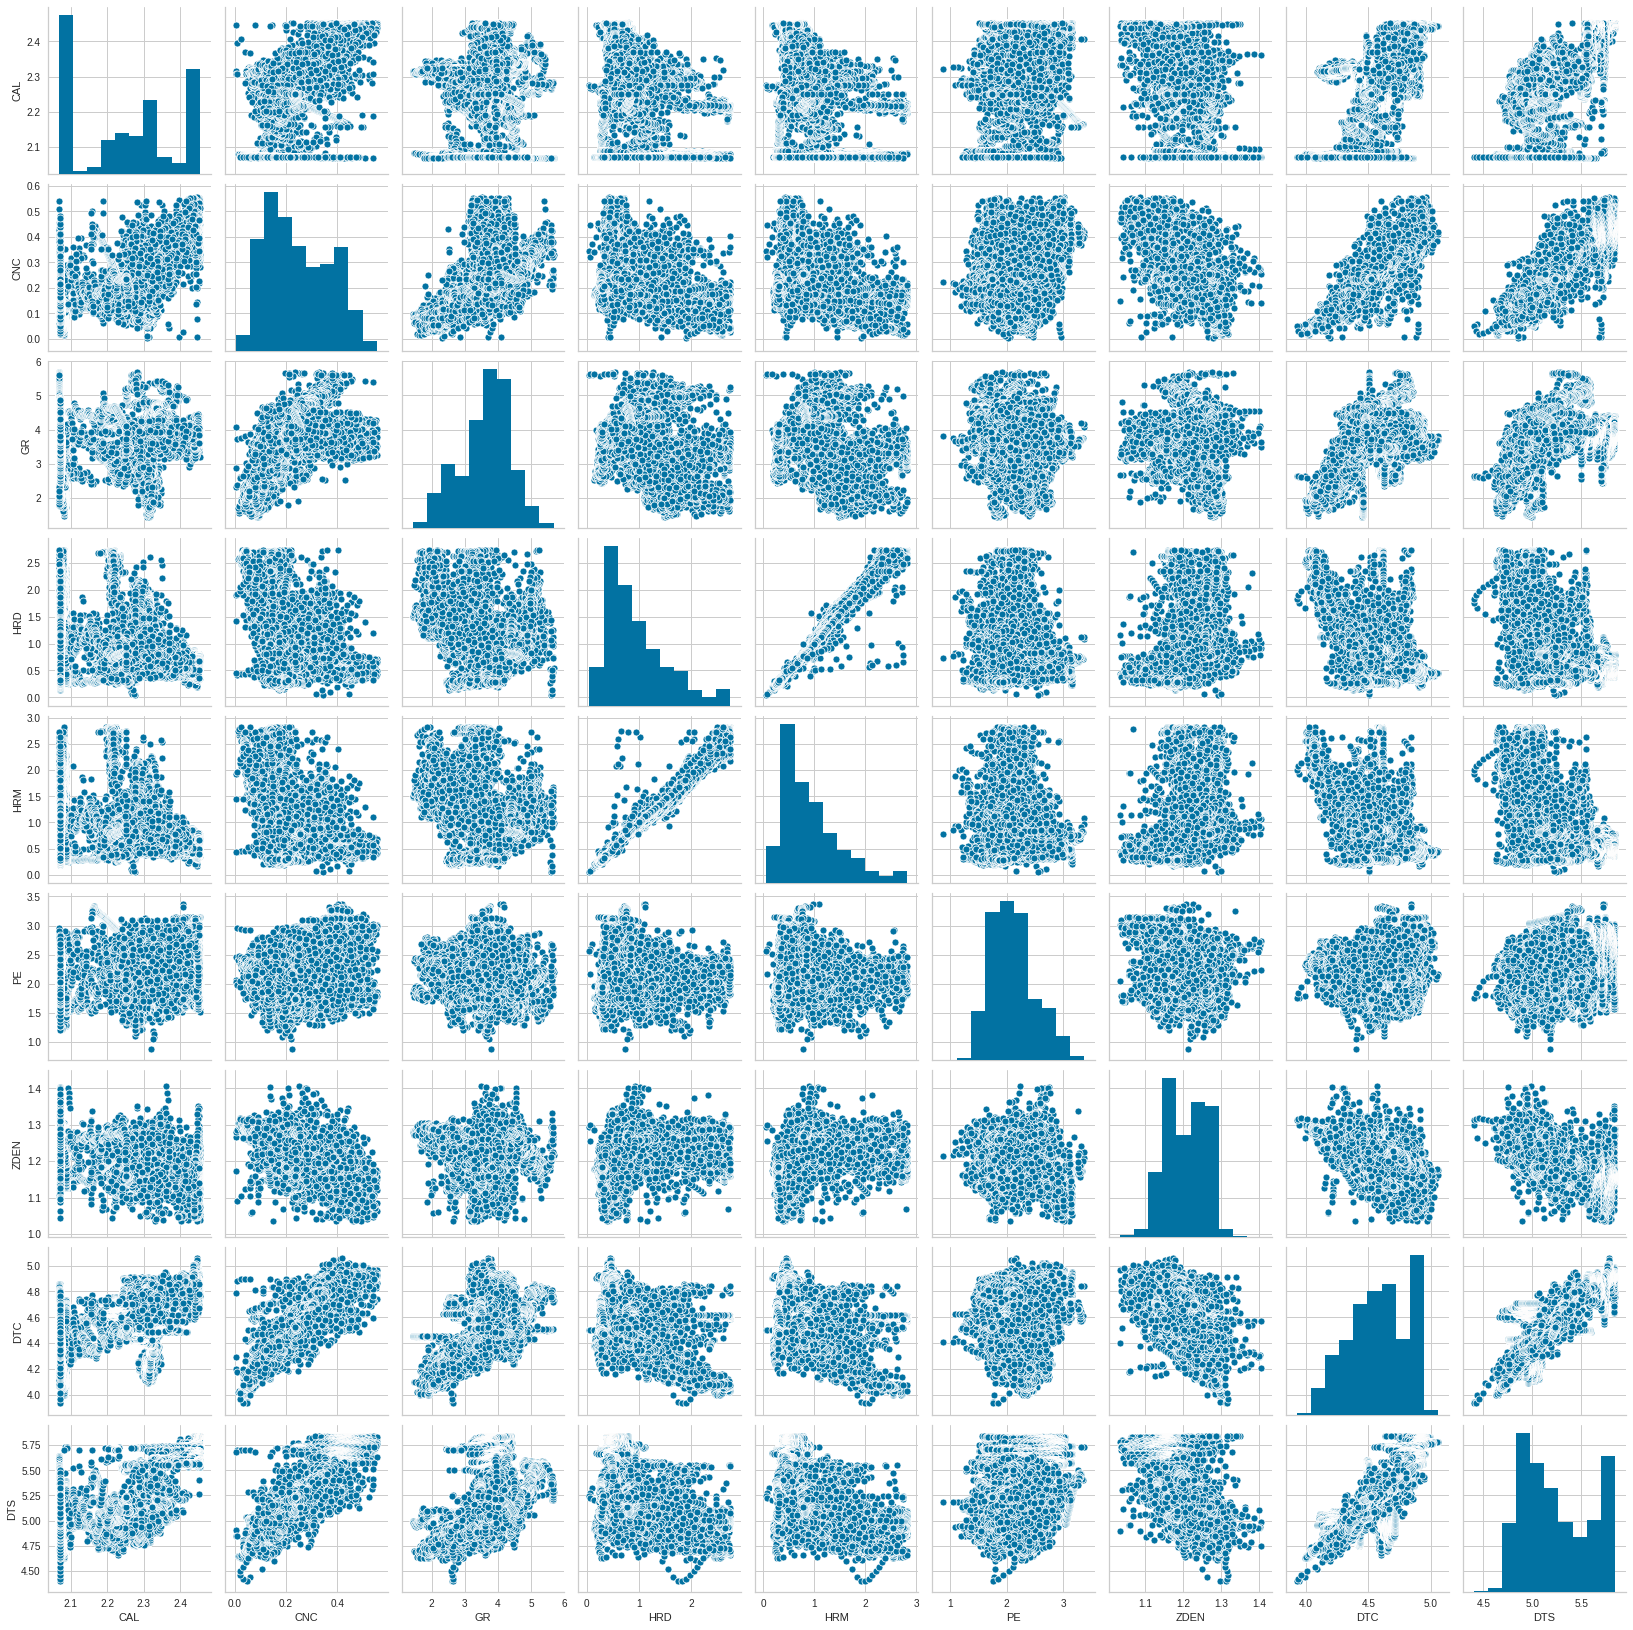

In [50]:
# apply log(1+x) transform
sns.pairplot(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False).apply(np.log1p))
plt.show()

Several predictors exhibit a degree of multicollinearity

* CNC & GR, which also exhibits heteroscedasticity
* CNC & ZDEN
* HRM & HRD

Feature ranking will be an important step, especially for any linear models

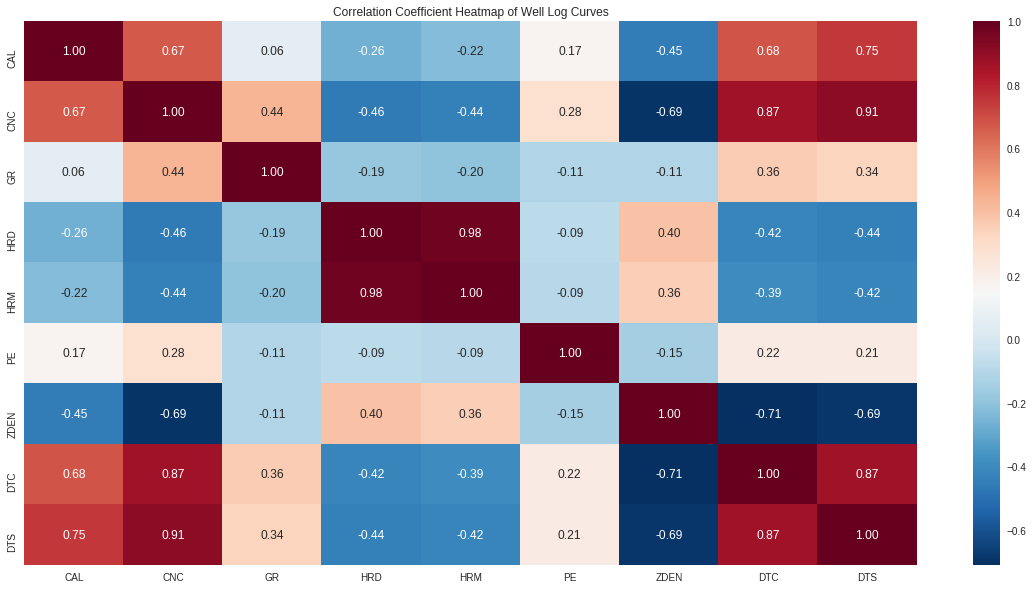

In [51]:
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False).corr(), cmap="RdBu_r", annot=True, fmt=".2f")
ax.set_title('Correlation Coefficient Heatmap of Well Log Curves')
plt.show()

Observations:

* CAL has reasonably high positive correlation to both DTC & DTS, as well as CNC.
* CNC has reasonably high positive correlation to CAL, GR, PE, as well as to DTC & DTS
* GR has moderate positive correlation to DTC & DTS
* HRD & HRM do not exhibit strong correlation with any other parameters than themselves, *but this could be due to the fact they are log-scale*
* PE has moderately positive correlation with CNC, DTC, & DTS
* ZDEN has a high negative correlation with CNC, DTC, & DTS, and mild negative correlation with CAL, GR, & PE

The recommendation going forward will be to drop CAL & HRM from the set of inputs.  Additionally we drop DTC & DTS in favor of the non-cleaned versions.

**Cleaned dataframe for proceeding:**

In [52]:
df = df_clean.copy()
df.drop(labels=['CAL','HRM','DTC','DTS'], axis=1, inplace=True)
df['DTC'] = df_w1['DTC']
df['DTS'] = df_w1['DTS']

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 7 columns):
CNC     29242 non-null float64
GR      29597 non-null float64
HRD     29266 non-null float64
PE      19260 non-null float64
ZDEN    29338 non-null float64
DTC     26089 non-null float64
DTS     25278 non-null float64
dtypes: float64(7)
memory usage: 1.6 MB


In [54]:
df.describe().transpose()

count        mean        std      min         25%        50%  \
CNC   29242.0    0.245878   0.153139   0.0041    0.126700    0.19760   
GR    29597.0   45.599358  40.336069   2.4213   18.100300   36.97310   
HRD   29266.0    2.328212   2.275687   0.0541    0.729100    1.61085   
PE    19260.0    7.887338   3.701148   1.4131    5.133575    6.95385   
ZDEN  29338.0    2.398611   0.175136   1.8139    2.236200    2.44090   
DTC   26089.0   91.814381  24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730  81.141960  80.5804  129.446625  144.59305   

             75%       max  
CNC     0.339275    0.7400  
GR     58.084100  299.9370  
HRD     3.086175   14.5584  
PE      9.296825   28.1064  
ZDEN    2.553300    3.0785  
DTC   112.112600  155.9803  
DTS   191.475125  487.4384

In [55]:
df.head()

CNC       GR  HRD  PE  ZDEN       DTC       DTS
0  NaN  41.4699  NaN NaN   NaN  128.0737  319.0654
1  NaN  42.5053  NaN NaN   NaN  127.8347  318.7825
2  NaN  43.1548  NaN NaN   NaN  127.2307  317.3323
3  NaN  43.2410  NaN NaN   NaN  126.2917  313.6486
4  NaN  40.3218  NaN NaN   NaN  125.3985  307.8903

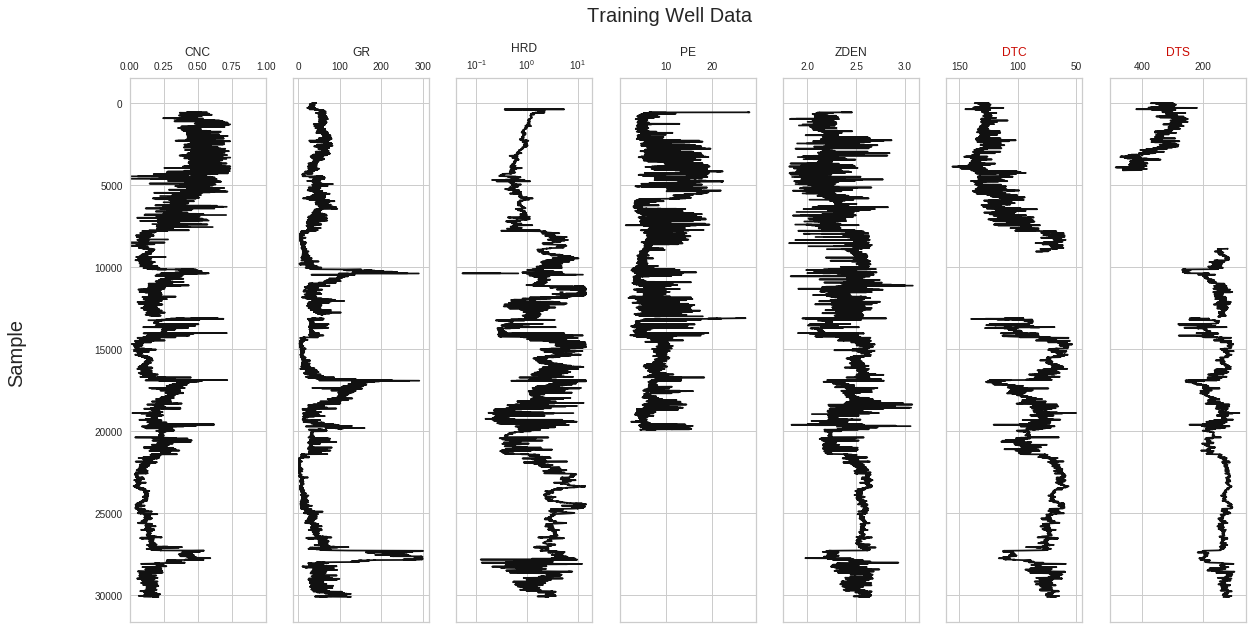

In [56]:
plot_well_curves(df)
plt.show()

### <a name="baseline"></a> 5) Baseline Model

back to [top](#top)

In this section, we build a baseline model without any feature selection, feature engineering, or parameter tuning to get a sense of model performance without any further steps.

In [57]:
df_baseline = df.copy()
df_baseline.drop(labels='PE', axis=1, inplace=True)
df_baseline.loc[:,['CNC','GR','HRD','ZDEN']].interpolate(limit_area='inside', inplace=True)
df_baseline.dropna(inplace=True)
df_baseline.reset_index(drop=True, inplace=True)

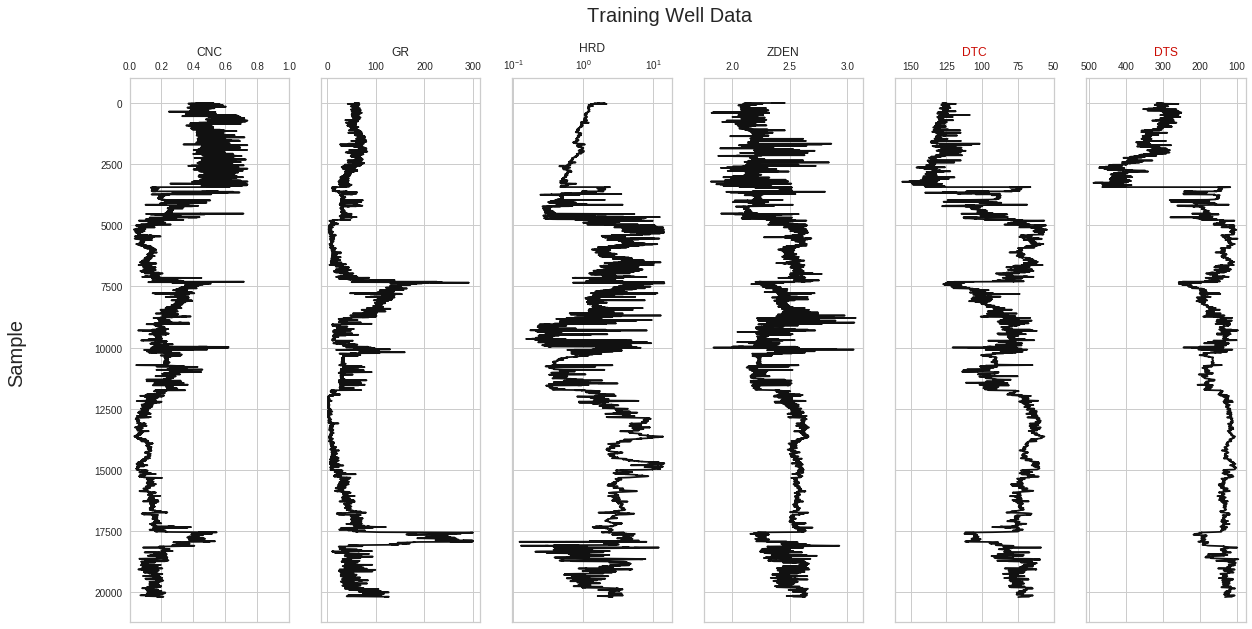

In [58]:
plot_well_curves(df_baseline)
plt.show()

In [59]:
X_baseline = df_baseline[['CNC','GR','HRD','ZDEN']]
y_baseline = df_baseline[['DTC','DTS']]

In [60]:
X_log_baseline = X_baseline.apply(lambda x: np.log(1 + x))

In [61]:
X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_log_baseline, y_baseline, test_size=0.2, random_state=random_state)

In [62]:
pipe_baseline_lr = make_pipeline(StandardScaler(), LinearRegression())

In [63]:
cvscore_baseline_lr = cross_val_score(pipe_baseline_lr, X_bs_train, y_bs_train, scoring=rmse_scorer, cv=5, n_jobs=-1)

In [64]:
print('5-fold CV RMSE Score for baseline LinearRegression: {}'.format(cvscore_baseline_lr))
print('Mean CV RMSE Score for baseline LinearRegression: {:.4f}'.format(cvscore_baseline_lr.mean()))

5-fold CV RMSE Score for baseline LinearRegression: [-23.93566355 -24.76071164 -25.02393839 -24.35996144 -24.18849824]
Mean CV RMSE Score for baseline LinearRegression: -24.4538


In [65]:
print('Train RMSE score for baseline LinearRegression: {:.4f}'.format(rmse_scorer(pipe_baseline_lr.fit(X_bs_train, y_bs_train), X_bs_train, y_bs_train)))
print('Test RMSE score for baseline LinearRegression: {:.4f}'.format(rmse_scorer(pipe_baseline_lr.fit(X_bs_train, y_bs_train), X_bs_test, y_bs_test)))

Train RMSE score for baseline LinearRegression: -24.4462
Test RMSE score for baseline LinearRegression: -24.5110


Now try a baseline RandomForest

In [66]:
X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_baseline, y_baseline, test_size=0.2, random_state=random_state)

In [67]:
rfr_baseline = RandomForestRegressor(random_state=random_state, oob_score=True)

In [68]:
cvscore_baseline_rfr = cross_val_score(rfr_baseline, X_bs_train, y_bs_train, scoring=rmse_scorer, cv=5, n_jobs=-1)

In [69]:
print('5-fold CV RMSE Score for baseline RandomForestRegressor: {}'.format(cvscore_baseline_rfr))
print('Mean CV RMSE Score for baseline RandomForestRegressor: {:.4f}'.format(cvscore_baseline_rfr.mean()))

5-fold CV RMSE Score for baseline RandomForestRegressor: [-9.89183013 -9.14019824 -9.77863344 -9.26566557 -9.80810671]
Mean CV RMSE Score for baseline RandomForestRegressor: -9.5769


In [70]:
rfr_baseline.fit(X_bs_train, y_bs_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [71]:
print('Train RMSE score for baseline RandomForestRegressor: {:.4f}'.format(rmse_scorer(rfr_baseline, X_bs_train, y_bs_train)))
print('Test RMSE score for baseline RandomForestRegressor: {:.4f}'.format(rmse_scorer(rfr_baseline, X_bs_test, y_bs_test)))

Train RMSE score for baseline RandomForestRegressor: -3.5364
Test RMSE score for baseline RandomForestRegressor: -9.4136


In [72]:
pd.DataFrame(data=rfr_baseline.feature_importances_, index=X_bs_train.columns, columns=['Feature Importances']).sort_values(by=['Feature Importances'], ascending=False)

Feature Importances
CNC              0.844928
HRD              0.107814
GR               0.032381
ZDEN             0.014876

The baseline Random Forest Regressor significantly outperforms the baseline Linear Regression.

Feature Importances suggest overwhelmingly that CNC is important in this model.  HRD contributes some, while GR & ZDEN have very little importance.

Default Feature Importances from Random Forest can be [misleading](https://explained.ai/rf-importance/index.html), however.

This should give us a good baseline upon which to evaluate other models's performance.

Use Permutation Importance to double check Random Forest's Feature Importance

In [73]:
imp_baseline = RFIMP.importances(rfr_baseline, X_bs_train, y_bs_train, n_samples=-1, metric=rmse_scorer(rfr_baseline, X_bs_train, y_bs_train))

/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in score

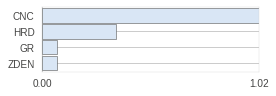

In [74]:
viz = RFIMP.plot_importances(imp_baseline)

Looking at this, it could make sense to drop ZDEN as an input predictor, at least for Random Forest

However, let's try dropping CNC first and see if it makes any difference

In [75]:
X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_baseline.drop(['CNC'], axis=1), y_baseline, test_size=0.2, random_state=random_state)

In [76]:
cvscore_baseline_rfr_v2 = cross_val_score(RandomForestRegressor(random_state=random_state), X_bs_train, y_bs_train, scoring=rmse_scorer, cv=5, n_jobs=-1)

/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [77]:
print('5-fold CV RMSE score RandomForest w/o CNC: {}'.format(cvscore_baseline_rfr_v2))
print('Mean CV RMSE score RandomForest w/o CNC: {:.4f}'.format(cvscore_baseline_rfr_v2.mean()))

5-fold CV RMSE score RandomForest w/o CNC: [-21.26733885 -18.40694869 -20.94169316 -21.53715668 -20.61752924]
Mean CV RMSE score RandomForest w/o CNC: -20.5541


In [78]:
pd.DataFrame(data=RandomForestRegressor(random_state=random_state).fit(X_bs_train, y_bs_train).feature_importances_,
            index=X_bs_train.columns, columns=['Feature Importances']).sort_values(by=['Feature Importances'], ascending=False)

Feature Importances
ZDEN             0.605558
HRD              0.268478
GR               0.125964

In [79]:
print('Train RMSE score: {:.4f}'.format(rmse_scorer(RandomForestRegressor(random_state=random_state).fit(X_bs_train, y_bs_train),
                                                   X_bs_train, y_bs_train)))
print('Test RMSE score: {:.4f}'.format(rmse_scorer(RandomForestRegressor(random_state=random_state).fit(X_bs_test, y_bs_test),
                                                  X_bs_test, y_bs_test)))

Train RMSE score: -7.6154
Test RMSE score: -8.3614


Ok, so CNC is actually pretty important.  Good to know.  The train score is worse without CNC.  Test score is somewhater better.  This suggests the baseline model without CNC is underfit.

### <a name="model"></a> 6) Model Selection & Tuning

1. [Random Forest Regressor](#random-forest)

1. [Gradient Boosting Regressor](#gbr)

1. [XGBoost Regressor](#xgb)

1. [AdaBoost Regressor](#abr)

1. [Kernelized Support Vector Regressor](#svm)

back to [top](#top)

In [80]:
df.head()

CNC       GR  HRD  PE  ZDEN       DTC       DTS
0  NaN  41.4699  NaN NaN   NaN  128.0737  319.0654
1  NaN  42.5053  NaN NaN   NaN  127.8347  318.7825
2  NaN  43.1548  NaN NaN   NaN  127.2307  317.3323
3  NaN  43.2410  NaN NaN   NaN  126.2917  313.6486
4  NaN  40.3218  NaN NaN   NaN  125.3985  307.8903

In [81]:
df_copy = df.copy()
df_copy.drop(labels=['PE'], axis=1, inplace=True)
df_copy.loc[:,['CNC','GR','HRD','ZDEN']].interpolate(limit_area='inside', inplace=True)
df_copy.dropna(inplace=True)
df_copy.reset_index(drop=True, inplace=True)

In [82]:
X = df_copy.drop(labels=['DTC', 'DTS'], axis=1)
y = df_copy[['DTC','DTS']]

In [83]:
print('X.shape: {}'.format(X.shape))
print('y.shape: {}'.format(y.shape))

X.shape: (20205, 4)
y.shape: (20205, 2)


In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20205 entries, 0 to 20204
Data columns (total 4 columns):
CNC     20205 non-null float64
GR      20205 non-null float64
HRD     20205 non-null float64
ZDEN    20205 non-null float64
dtypes: float64(4)
memory usage: 631.5 KB


In [85]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20205 entries, 0 to 20204
Data columns (total 2 columns):
DTC    20205 non-null float64
DTS    20205 non-null float64
dtypes: float64(2)
memory usage: 315.8 KB


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

<a name="random-forest"></a>**Random Forest Regressor**

back to [Model](#model)

In [87]:
pipe_rfr = model_eval(RandomForestRegressor(random_state=random_state), X_train, y_train, scoring=rmse_scorer, cv=5, n_jobs=-1)

5-fold CV RMSE score for RandomForestRegressor is [-9.89183013 -9.14019824 -9.77863344 -9.26566557 -9.80810671]:
Mean CV RMSE score for RandomForestRegressor is -9.5769


In [88]:
print('Train score: {:.4f}'.format(r2_scorer(pipe_rfr.named_steps['randomforestregressor'], X_train, y_train)))
print('Train RMSE score: {:.4f}\n'.format(-1*rmse_scorer(pipe_rfr.named_steps['randomforestregressor'], X_train, y_train)))
print('Test score: {:.4f}'.format(r2_scorer(pipe_rfr.named_steps['randomforestregressor'], X_test, y_test)))
print('Test RMSE score: {:.4f}'.format(-1*rmse_scorer(pipe_rfr.named_steps['randomforestregressor'], X_test, y_test)))

Train score: 0.9968
Train RMSE score: 3.5364

Test score: 0.9768
Test RMSE score: 9.4136


In [89]:
pd.DataFrame(data=pipe_rfr.named_steps['randomforestregressor'].feature_importances_,
             index=X_train.columns,
             columns=['Feature Importances']).sort_values(by=['Feature Importances'], ascending=False)

Feature Importances
CNC              0.844928
HRD              0.107814
GR               0.032381
ZDEN             0.014876

In [90]:
pipe_rfr.named_steps['randomforestregressor'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [91]:
rfr_param_grid = {
    'n_estimators': [int(x) for x in np.arange(100,350,50)],
    'max_depth': [None, 10, 50, 100],
    'max_features': [1, 2, 3, 'auto'],
}

In [92]:
print('Random Forest param grid:\n')
pprint(rfr_param_grid)

Random Forest param grid:

{'max_depth': [None, 10, 50, 100],
 'max_features': [1, 2, 3, 'auto'],
 'n_estimators': [100, 150, 200, 250, 300]}


In [93]:
rfr = RandomForestRegressor(random_state=random_state)

In [94]:
grid_rfr = GridSearchCV(rfr, rfr_param_grid, scoring=rmse_scorer, n_jobs=-1, cv=5, verbose=2)

In [95]:
print('Grid Search start time: {}'.format(time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime())))
grid_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 10.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [96]:
grid_rfr.best_params_

{'max_depth': None, 'max_features': 2, 'n_estimators': 250}

In [97]:
print('Tuned RFR Mean CV RMSE Score: {:.4f}\n'.format(-1*grid_rfr.best_score_))
print('Tuned RFR RMSE Train Score: {:.4f}'.format(-1*grid_rfr.score(X_train, y_train)))
print('Tuned RFR r2 Train Score: {:.4f}\n'.format(r2_scorer(grid_rfr.best_estimator_, X_train, y_train)))
print('Tuned RFR RMSE Test Score: {:.4f}'.format(-1*grid_rfr.score(X_test, y_test)))
print('TUned RFR r2 Test Score: {:.4f}'.format(r2_scorer(grid_rfr.best_estimator_, X_test, y_test)))

Tuned RFR Mean CV RMSE Score: 9.3056

Tuned RFR RMSE Train Score: 3.4111
Tuned RFR r2 Train Score: 0.9970

Tuned RFR RMSE Test Score: 9.1339
TUned RFR r2 Test Score: 0.9780


In [100]:
grid_rfr_results = pd.DataFrame(data=grid_rfr.cv_results_)

In [101]:
grid_rfr_results.iloc[grid_rfr.best_index_]

mean_fit_time                                                   6.87488
std_fit_time                                                   0.108433
mean_score_time                                                0.196212
std_score_time                                               0.00109102
param_max_depth                                                    None
param_max_features                                                    2
param_n_estimators                                                  250
params                {'max_depth': None, 'max_features': 2, 'n_esti...
split0_test_score                                              -9.94511
split1_test_score                                              -8.87437
split2_test_score                                              -9.38776
split3_test_score                                              -8.96734
split4_test_score                                               -9.3535
mean_test_score                                                -

In [102]:
grid_rfr_scores = np.array(grid_rfr_results.mean_test_score).reshape(4,4,5)

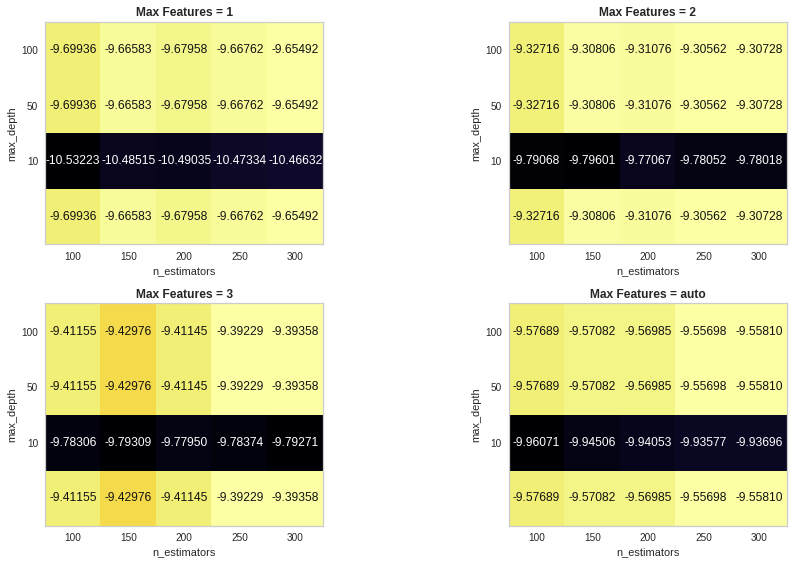

In [117]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

heatmap(grid_rfr_scores[:,0,:], xlabel='n_estimators', xticklabels=rfr_param_grid['n_estimators'],
        ylabel='max_depth', yticklabels=rfr_param_grid['max_depth'], cmap='inferno', ax=ax[0,0], fmt='%0.5f')
ax[0,0].set_title('Max Features = 1', fontweight='bold')

heatmap(grid_rfr_scores[:,1,:], xlabel='n_estimators', xticklabels=rfr_param_grid['n_estimators'],
        ylabel='max_depth', yticklabels=rfr_param_grid['max_depth'], cmap='inferno', ax=ax[0,1], fmt='%0.5f')
ax[0,1].set_title('Max Features = 2', fontweight='bold')

heatmap(grid_rfr_scores[:,2,:], xlabel='n_estimators', xticklabels=rfr_param_grid['n_estimators'],
       ylabel='max_depth', yticklabels=rfr_param_grid['max_depth'], cmap='inferno', ax=ax[1,0], fmt='%0.5f')
ax[1,0].set_title('Max Features = 3', fontweight='bold')

heatmap(grid_rfr_scores[:,3,:], xlabel='n_estimators', xticklabels=rfr_param_grid['n_estimators'],
       ylabel='max_depth', yticklabels=rfr_param_grid['max_depth'], cmap='inferno', ax=ax[1,1], fmt='%0.5f')
ax[1,1].set_title('Max Features = auto', fontweight='bold')

plt.tight_layout()
plt.show()

In [118]:
tree_depths = [estimator.get_depth() for estimator in grid_rfr.best_estimator_.estimators_]

In [121]:
print('Mean tree depth in tuned Random Forest: {}'.format(int(np.round(np.mean(tree_depths)))))
print('Min tree depth in tuned Random Forest: {}'.format(int(np.round(np.min(tree_depths)))))
print('Max tree depth in tuned Random Forest: {}'.format(int(np.round(np.max(tree_depths)))))

Mean tree depth in tuned Random Forest: 37
Min tree depth in tuned Random Forest: 30
Max tree depth in tuned Random Forest: 44


This is a good increase in performance over the non-tuned Random Forest.

Although 'max_depth' = None is selected as the best estimator, it appears that there is not any appreciable difference in performance between 'max_depth' = 50 or 100

This makes sense because when we don't apply pruning, the maximum tree depth never gets larger than 44 nodes.

<a name="gbr"></a>**Gradient Boosting Regressor**

back to [Model](#model)

In [122]:
pipe_gbr = model_eval(MultiOutputRegressor(GradientBoostingRegressor(random_state=random_state)), X_train, y_train, scoring=rmse_scorer, cv=5, n_jobs=-1)

5-fold CV RMSE score for MultiOutputRegressor is [-11.71975548 -10.65587714 -11.45298544 -10.79594856 -11.58660663]:
Mean CV RMSE score for MultiOutputRegressor is -11.2422


In [123]:
print('Train score: {:.4f}'.format(r2_scorer(pipe_gbr.named_steps['multioutputregressor'], X_train, y_train)))
print('Train RMSE score: {:.4f}\n'.format(-1*rmse_scorer(pipe_gbr.named_steps['multioutputregressor'], X_train, y_train)))
print('Test score: {:.4f}'.format(r2_scorer(pipe_gbr.named_steps['multioutputregressor'], X_test, y_test)))
print('Test RMSE score: {:.4f}'.format(-1*rmse_scorer(pipe_gbr.named_steps['multioutputregressor'], X_test, y_test)))

Train score: 0.9713
Train RMSE score: 10.4920

Test score: 0.9668
Test RMSE score: 11.2900


In [124]:
pd.DataFrame(data=np.array([pipe_gbr.named_steps['multioutputregressor'].estimators_[0].feature_importances_,
                           pipe_gbr.named_steps['multioutputregressor'].estimators_[1].feature_importances_]).T,
            index=X_train.columns,
            columns=['Feature Importances DTC', 'Feature Importances DTS']).sort_values(by=['Feature Importances DTC'], ascending=False)

Feature Importances DTC  Feature Importances DTS
CNC                  0.915081                 0.858167
ZDEN                 0.036639                 0.009550
GR                   0.024442                 0.020482
HRD                  0.023838                 0.111800

In [138]:
gbr = make_pipeline(MultiOutputRegressor(GradientBoostingRegressor(random_state=random_state)))

In [160]:
gbr.named_steps['multioutputregressor'].estimator

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [173]:
gbr_param_grid = {
    'multioutputregressor__estimator__learning_rate': [0.01, 0.05, 0.1, 0.5],
    'multioutputregressor__estimator__max_features': [1, 2],
    'multioutputregressor__estimator__n_estimators': [1000, 2000, 3000, 4000, 5000],
}

In [174]:
print('Param Grid for GBR Grid Search:\n')
pprint(gbr_param_grid)

Param Grid for GBR Grid Search:

{'multioutputregressor__estimator__learning_rate': [0.01, 0.05, 0.1, 0.5],
 'multioutputregressor__estimator__max_features': [1, 2],
 'multioutputregressor__estimator__n_estimators': [1000,
                                                   2000,
                                                   3000,
                                                   4000,
                                                   5000]}


In [175]:
grid_gbr = GridSearchCV(gbr, gbr_param_grid, scoring=rmse_scorer, n_jobs=-1, cv=5, verbose=2)

In [176]:
print('Grid Search start time: {}'.format(time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime())))
grid_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 31.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('multioutputregressor',
                                        MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                                                                 ccp_alpha=0.0,
                                                                                                 criterion='friedman_mse',
                                                                                                 init=None,
                                                                                                 learning_rate=0.1,
                                                                                                 loss='ls',
                                                                                                 max_depth=3,
                                                                      

In [177]:
grid_gbr.best_params_

{'multioutputregressor__estimator__learning_rate': 0.05,
 'multioutputregressor__estimator__max_features': 2,
 'multioutputregressor__estimator__n_estimators': 3000}

In [178]:
print('Tuned GBR Mean CV RMSE Score: {:.4f}\n'.format(-1*grid_gbr.best_score_))
print('Tuned GBR RMSE Train Score: {:.4f}'.format(-1*grid_gbr.score(X_train, y_train)))
print('Tuned GBR r2 Train Score: {:.4f}\n'.format(r2_scorer(grid_gbr.best_estimator_, X_train, y_train)))
print('Tuned GBR RMSE Test Score: {:.4f}'.format(-1*grid_gbr.score(X_test, y_test)))
print('TUned GBR r2 Test Score: {:.4f}'.format(r2_scorer(grid_gbr.best_estimator_, X_test, y_test)))

Tuned GBR Mean CV RMSE Score: 10.4935

Tuned GBR RMSE Train Score: 7.0885
Tuned GBR r2 Train Score: 0.9863

Tuned GBR RMSE Test Score: 10.4524
TUned GBR r2 Test Score: 0.9718


Well, we have improved the baseline Gradient Boosted Regressor performance, but are not performing as well as the Random Forest.

Try searching for a better max_depth with the GridSearchCV output best_estimator_

In [184]:
grid_gbr_maxdepth = GridSearchCV(grid_gbr.best_estimator_, 
                                 param_grid={'multioutputregressor__estimator__max_depth':[int(x) for x in np.arange(3,33,3)]},
                                 scoring=rmse_scorer, n_jobs=-1, cv=5, verbose=2)

In [185]:
print('Grid Search start time: {}'.format(time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime())))
grid_gbr_maxdepth.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('multioutputregressor',
                                        MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                                                                 ccp_alpha=0.0,
                                                                                                 criterion='friedman_mse',
                                                                                                 init=None,
                                                                                                 learning_rate=0.05,
                                                                                                 loss='ls',
                                                                                                 max_depth=3,
                                                                     

In [186]:
grid_gbr_maxdepth.best_params_

{'multioutputregressor__estimator__max_depth': 21}

In [187]:
print('Tuned GBR Mean CV RMSE Score: {:.4f}\n'.format(-1*grid_gbr_maxdepth.best_score_))
print('Tuned GBR RMSE Train Score: {:.4f}'.format(-1*grid_gbr_maxdepth.score(X_train, y_train)))
print('Tuned GBR r2 Train Score: {:.4f}\n'.format(r2_scorer(grid_gbr_maxdepth.best_estimator_, X_train, y_train)))
print('Tuned GBR RMSE Test Score: {:.4f}'.format(-1*grid_gbr_maxdepth.score(X_test, y_test)))
print('TUned GBR r2 Test Score: {:.4f}'.format(r2_scorer(grid_gbr_maxdepth.best_estimator_, X_test, y_test)))

Tuned GBR Mean CV RMSE Score: 9.2973

Tuned GBR RMSE Train Score: 0.0003
Tuned GBR r2 Train Score: 1.0000

Tuned GBR RMSE Test Score: 9.0622
TUned GBR r2 Test Score: 0.9784


That totally eliminates error on the training set, and while it is lower, there is still error on the test set.  This model might be overfit and may not generalize well.

**This is better performance than the tuned Random Forest**

Maybe this could be combined with our tuned Random Forest in an ensemble.

Let's try one more grid search ...

In [193]:
gbr_param_grid_v2 = {
    'multioutputregressor__estimator__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'multioutputregressor__estimator__max_features': [1, 2, None],
    'multioutputregressor__estimator__max_depth': [4, 6, 8, 10],
    'multioutputregressor__estimator__n_estimators': [500, 1000, 1500, 2000],
    'multioutputregressor__estimator__n_iter_no_change': [5],
}

In [194]:
print('Param Grid for GBR Grid Search:\n')
pprint(gbr_param_grid_v2)

Param Grid for GBR Grid Search:

{'multioutputregressor__estimator__learning_rate': [0.001,
                                                    0.005,
                                                    0.01,
                                                    0.05,
                                                    0.1,
                                                    0.5],
 'multioutputregressor__estimator__max_depth': [4, 6, 8, 10],
 'multioutputregressor__estimator__max_features': [1, 2, None],
 'multioutputregressor__estimator__n_estimators': [500, 1000, 1500, 2000],
 'multioutputregressor__estimator__n_iter_no_change': [5]}


In [195]:
grid_gbr_v2 = GridSearchCV(gbr, gbr_param_grid_v2, scoring=rmse_scorer, n_jobs=-1, cv=5, verbose=2)

In [196]:
print('Grid Search start time: {}'.format(time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime())))
grid_gbr_v2.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 84.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 97.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 100.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('multioutputregressor',
                                        MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                                                                 ccp_alpha=0.0,
                                                                                                 criterion='friedman_mse',
                                                                                                 init=None,
                                                                                                 learning_rate=0.1,
                                                                                                 loss='ls',
                                                                                                 max_depth=3,
                                                                      

In [197]:
grid_gbr_v2.best_params_

{'multioutputregressor__estimator__learning_rate': 0.005,
 'multioutputregressor__estimator__max_depth': 10,
 'multioutputregressor__estimator__max_features': 2,
 'multioutputregressor__estimator__n_estimators': 1500,
 'multioutputregressor__estimator__n_iter_no_change': 5}

In [198]:
print('Tuned GBR Mean CV RMSE Score: {:.4f}\n'.format(-1*grid_gbr_v2.best_score_))
print('Tuned GBR RMSE Train Score: {:.4f}'.format(-1*grid_gbr_v2.score(X_train, y_train)))
print('Tuned GBR r2 Train Score: {:.4f}\n'.format(r2_scorer(grid_gbr_v2.best_estimator_, X_train, y_train)))
print('Tuned GBR RMSE Test Score: {:.4f}'.format(-1*grid_gbr_v2.score(X_test, y_test)))
print('TUned GBR r2 Test Score: {:.4f}'.format(r2_scorer(grid_gbr_v2.best_estimator_, X_test, y_test)))

Tuned GBR Mean CV RMSE Score: 9.4207

Tuned GBR RMSE Train Score: 4.5242
Tuned GBR r2 Train Score: 0.9944

Tuned GBR RMSE Test Score: 8.9560
TUned GBR r2 Test Score: 0.9782


Ok!  The train RMSE is higher than on the previous, but this is the best Test RMSE we have achieved so far.

Compared to the tuned Random Forest, the Train RMSE is somewhat higher, but the Test RMSE is lower.

<a name="xgb"></a>**XGBoost Regressor**

back to [Model](#model)

In [199]:
pipe_xgb = model_eval(MultiOutputRegressor(xgb.XGBRegressor(random_state=random_state)), X_train, y_train, scoring=rmse_scorer, cv=5, n_jobs=-1)

5-fold CV RMSE score for MultiOutputRegressor is [-10.44179941  -9.44210357  -9.95091051  -9.73178721 -10.08439827]:
Mean CV RMSE score for MultiOutputRegressor is -9.9302


In [200]:
print('Train score: {:.4f}'.format(r2_scorer(pipe_xgb.named_steps['multioutputregressor'], X_train, y_train)))
print('Train RMSE score: {:.4f}\n'.format(-1*rmse_scorer(pipe_xgb.named_steps['multioutputregressor'], X_train, y_train)))
print('Test score: {:.4f}'.format(r2_scorer(pipe_xgb.named_steps['multioutputregressor'], X_test, y_test)))
print('Test RMSE score: {:.4f}'.format(-1*rmse_scorer(pipe_xgb.named_steps['multioutputregressor'], X_test, y_test)))

Train score: 0.9907
Train RMSE score: 5.6161

Test score: 0.9732
Test RMSE score: 10.0911


In [201]:
pd.DataFrame(data=np.array([pipe_xgb.named_steps['multioutputregressor'].estimators_[0].feature_importances_,
                           pipe_xgb.named_steps['multioutputregressor'].estimators_[1].feature_importances_]).T,
            index=X_train.columns,
            columns=['Feature Importances DTC', 'Feature Importances DTS']).sort_values(by=['Feature Importances DTC'], ascending=False)

Feature Importances DTC  Feature Importances DTS
CNC                  0.908436                 0.832710
ZDEN                 0.037938                 0.012226
GR                   0.031068                 0.026272
HRD                  0.022558                 0.128792

Consistently, CNC & GR/ZDEN are most important for DTC while CNC & HRD are most important for DTS

In [202]:
xgbr = make_pipeline(MultiOutputRegressor(xgb.XGBRegressor(random_state=random_state)))

In [204]:
xgbr.named_steps['multioutputregressor'].estimator.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None}

In [205]:
xgbr_param_grid = {
    'multioutputregressor__estimator__booster': ['gbtree'],
    'multioutputregressor__estimator__learning_rate': [0.001, 0.01, 0.1],
    'multioutputregressor__estimator__gamma': [0, 1, 10],
    'multioutputregressor__estimator__n_estimators': [100, 500, 1000],
    'multioutputregressor__estimator__max_depth': [int(x) for x in np.arange(2,11,2)],
    'multioutputregressor__estimator__subsample': [0.8, 1],
    'multioutputregressor__estimator__colsample_bytree': [0.8, 1],
    'multioutputregressor__estimator__eval_metric': ['rmse'],
}

In [206]:
print('Param Grid for XGBR Grid Search:\n')
pprint(xgbr_param_grid)

Param Grid for XGBR Grid Search:

{'multioutputregressor__estimator__booster': ['gbtree'],
 'multioutputregressor__estimator__colsample_bytree': [0.8, 1],
 'multioutputregressor__estimator__eval_metric': ['rmse'],
 'multioutputregressor__estimator__gamma': [0, 1, 10],
 'multioutputregressor__estimator__learning_rate': [0.001, 0.01, 0.1],
 'multioutputregressor__estimator__max_depth': [2, 4, 6, 8, 10],
 'multioutputregressor__estimator__n_estimators': [100, 500, 1000],
 'multioutputregressor__estimator__subsample': [0.8, 1]}


In [207]:
grid_xgbr = GridSearchCV(xgbr, xgbr_param_grid, scoring=rmse_scorer, n_jobs=-1, cv=5, verbose=2)

In [208]:
print('Grid Search start time: {}'.format(time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime())))
grid_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 98.1min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 104.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('multioutputregressor',
                                        MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                                    booster=None,
                                                                                    colsample_bylevel=None,
                                                                                    colsample_bynode=None,
                                                                                    colsample_bytree=None,
                                                                                    gamma=None,
                                                                                    gpu_id=None,
                                                                                    importance_type='gain',
                                 

In [210]:
grid_xgbr.best_params_

{'multioutputregressor__estimator__booster': 'gbtree',
 'multioutputregressor__estimator__colsample_bytree': 1,
 'multioutputregressor__estimator__eval_metric': 'rmse',
 'multioutputregressor__estimator__gamma': 1,
 'multioutputregressor__estimator__learning_rate': 0.01,
 'multioutputregressor__estimator__max_depth': 10,
 'multioutputregressor__estimator__n_estimators': 1000,
 'multioutputregressor__estimator__subsample': 0.8}

In [211]:
print('Tuned XGBR Mean CV RMSE Score: {:.4f}\n'.format(-1*grid_xgbr.best_score_))
print('Tuned XGBR RMSE Train Score: {:.4f}'.format(-1*grid_xgbr.score(X_train, y_train)))
print('Tuned XGBR r2 Train Score: {:.4f}\n'.format(r2_scorer(grid_xgbr.best_estimator_, X_train, y_train)))
print('Tuned XGBR RMSE Test Score: {:.4f}'.format(-1*grid_xgbr.score(X_test, y_test)))
print('Tuned XGBR r2 Test Score: {:.4f}'.format(r2_scorer(grid_xgbr.best_estimator_, X_test, y_test)))

Tuned XGBR Mean CV RMSE Score: 9.3882

Tuned XGBR RMSE Train Score: 4.1497
Tuned XGBR r2 Train Score: 0.9945

Tuned XGBR RMSE Test Score: 9.6397
Tuned XGBR r2 Test Score: 0.9758


XGBRegressor Train score is better than GBDT Regressor, but Test score is worse.  The model may be overfit and further tuning may be needed.

<a name="abr"></a>**AdaBoost Regressor**

Back to [Model](#model)

In [212]:
pipe_abr = model_eval(MultiOutputRegressor(AdaBoostRegressor(random_state=random_state)), X_train, y_train, scoring=rmse_scorer, cv=5, n_jobs=-1)

5-fold CV RMSE score for MultiOutputRegressor is [-17.28709046 -16.5861448  -17.38340008 -16.07571539 -16.86123809]:
Mean CV RMSE score for MultiOutputRegressor is -16.8387


In [213]:
print('Train score: {:.4f}'.format(r2_scorer(pipe_abr.named_steps['multioutputregressor'], X_train, y_train)))
print('Train RMSE score: {:.4f}\n'.format(-1*rmse_scorer(pipe_abr.named_steps['multioutputregressor'], X_train, y_train)))
print('Test score: {:.4f}'.format(r2_scorer(pipe_abr.named_steps['multioutputregressor'], X_test, y_test)))
print('Test RMSE score: {:.4f}'.format(-1*rmse_scorer(pipe_abr.named_steps['multioutputregressor'], X_test, y_test)))

Train score: 0.9208
Train RMSE score: 15.6823

Test score: 0.9175
Test RMSE score: 16.3089


In [214]:
pd.DataFrame(data=np.array([pipe_abr.named_steps['multioutputregressor'].estimators_[0].feature_importances_,
                           pipe_abr.named_steps['multioutputregressor'].estimators_[1].feature_importances_]).T,
            index=X_train.columns,
            columns=['Feature Importances DTC', 'Feature Importances DTS']).sort_values(by=['Feature Importances DTC'], ascending=False)

Feature Importances DTC  Feature Importances DTS
CNC                  0.502592                 0.569228
HRD                  0.195910                 0.243448
ZDEN                 0.153907                 0.098621
GR                   0.147590                 0.088703

In [215]:
abr = make_pipeline(MultiOutputRegressor(AdaBoostRegressor(random_state=random_state)))

In [216]:
abr.named_steps['multioutputregressor'].estimator.get_params()

{'base_estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 42}

In [217]:
abr_param_grid = {
    'multioutputregressor__estimator__n_estimators': [50, 100, 250, 500, 1000, 2000],
    'multioutputregressor__estimator__learning_rate': [0.01, 0.1, 1, 2, 4, 8, 16],
}

In [218]:
grid_abr = GridSearchCV(abr, abr_param_grid, scoring=rmse_scorer, n_jobs=-1, cv=5, verbose=2)

In [219]:
print('Grid Search start time: {}'.format(time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime())))
grid_abr.fit(X_train, y_train)

Grid Search start time: Sat, 25 Apr 2020 16:05:16
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('multioutputregressor',
                                        MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=None,
                                                                                         learning_rate=1.0,
                                                                                         loss='linear',
                                                                                         n_estimators=50,
                                                                                         random_state=42),
                                                             n_jobs=None))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'multioutputregressor__estimator__learning_rate': [0.01,
                                                                       

In [220]:
grid_abr.best_params_

{'multioutputregressor__estimator__learning_rate': 0.01,
 'multioutputregressor__estimator__n_estimators': 100}

In [221]:
print('Tuned ABR Mean CV RMSE Score: {:.4f}\n'.format(-1*grid_abr.best_score_))
print('Tuned ABR RMSE Train Score: {:.4f}'.format(-1*grid_abr.score(X_train, y_train)))
print('Tuned ABR r2 Train Score: {:.4f}\n'.format(r2_scorer(grid_abr.best_estimator_, X_train, y_train)))
print('Tuned ABR RMSE Test Score: {:.4f}'.format(-1*grid_abr.score(X_test, y_test)))
print('Tuned ABR r2 Test Score: {:.4f}'.format(r2_scorer(grid_abr.best_estimator_, X_test, y_test)))

Tuned ABR Mean CV RMSE Score: 14.9918

Tuned ABR RMSE Train Score: 14.3952
Tuned ABR r2 Train Score: 0.9399

Tuned ABR RMSE Test Score: 15.0519
TUned ABR r2 Test Score: 0.9358


AdaBoost Regressor is not performing very well.  Spending more time tuning may not be worth it.

<a name="svm"></a>**Support Vector Machines Regressor**

back to [Model](#model)

In [222]:
pipe_svr = model_eval(MultiOutputRegressor(SVR()), X_train.apply(np.log1p), y_train, preprocessing=StandardScaler(), scoring=rmse_scorer, cv=5, n_jobs=-1)

5-fold CV RMSE score for MultiOutputRegressor is [-16.01099034 -15.70157068 -17.25442498 -16.38295668 -16.21719153]:
Mean CV RMSE score for MultiOutputRegressor is -16.3134


In [224]:
svr = make_pipeline(StandardScaler(), MultiOutputRegressor(SVR()))

In [225]:
svr.named_steps['multioutputregressor'].estimator.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [230]:
svr_param_grid = {
    'multioutputregressor__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'multioutputregressor__estimator__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

In [231]:
print('SVR param search grid:\n')
pprint(svr_param_grid)

SVR param search grid:

{'multioutputregressor__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'multioutputregressor__estimator__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [232]:
grid_svr = GridSearchCV(svr, svr_param_grid, scoring=rmse_scorer, n_jobs=-1, cv=5, verbose=2)

In [233]:
print('Grid Search start time: {}'.format(time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime())))
grid_svr.fit(X_train, y_train)

Grid Search start time: Sat, 25 Apr 2020 16:19:52
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 107.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=SVR(C=1.0,
                                                                           cache_size=200,
                                                                           coef0=0.0,
                                                                           degree=3,
                                                                           epsilon=0.1,
                                                                           gamma='scale',
                                                                  

In [234]:
grid_svr.best_params_

{'multioutputregressor__estimator__C': 1000,
 'multioutputregressor__estimator__gamma': 1}

In [236]:
print('Mean CV RMSE Score: {:.4f}\n'.format(-1*grid_svr.best_score_))
print('Tuned SVR RMSE Train Score: {:.4f}'.format(-1*grid_svr.score(X_train, y_train)))
print('Tuned SVR r2 Train Score: {:.4f}\n'.format(r2_scorer(grid_svr.best_estimator_, X_train, y_train)))
print('Tuned SVR RMSE Test Score: {:.4f}'.format(-1*grid_svr.score(X_test, y_test)))
print('Tuned SVR r2 Test Score: {:.4f}'.format(r2_scorer(grid_svr.best_estimator_, X_test, y_test)))

make_pipelineVR Mean CV RMSE Score: 11.2394

Tuned SVR RMSE Train Score: 10.3208
Tuned SVR r2 Train Score: 0.9750

Tuned SVR RMSE Test Score: 11.8306
Tuned SVR r2 Test Score: 0.9656


Those results are not very impressive.  Perhaps applying a log transform to the features ahead of scaling will help.

Try a smaller search space.  Also it could be worth trying both StandardScaler and MinMaxScaler

In [241]:
svr_v2 = make_pipeline(FunctionTransformer(func=np.log1p, inverse_func=np.expm1), StandardScaler(), MultiOutputRegressor(SVR()))

In [243]:
svr_v2.named_steps

{'functiontransformer': FunctionTransformer(accept_sparse=False, check_inverse=True,
                     func=<ufunc 'log1p'>, inv_kw_args=None,
                     inverse_func=<ufunc 'expm1'>, kw_args=None, validate=False),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'multioutputregressor': MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                    epsilon=0.1, gamma='scale', kernel='rbf',
                                    max_iter=-1, shrinking=True, tol=0.001,
                                    verbose=False),
                      n_jobs=None)}

In [245]:
svr_v2_param_grid = {
    'standardscaler': [StandardScaler(), MinMaxScaler()],
    'multioutputregressor__estimator__C': [10, 100, 1000],
    'multioutputregressor__estimator__gamma': [0.1, 1, 10],
}

In [246]:
grid_svr_v2 = GridSearchCV(svr_v2, svr_v2_param_grid, scoring=rmse_scorer, n_jobs=-1, cv=5, verbose=2)

In [247]:
print('Grid Search start time: {}'.format(time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime())))
grid_svr_v2.fit(X_train, y_train)

Grid Search start time: Sat, 25 Apr 2020 19:48:38
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 109.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('functiontransformer',
                                        FunctionTransformer(accept_sparse=False,
                                                            check_inverse=True,
                                                            func=<ufunc 'log1p'>,
                                                            inv_kw_args=None,
                                                            inverse_func=<ufunc 'expm1'>,
                                                            kw_args=None,
                                                            validate=False)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                          

In [248]:
grid_svr_v2.best_params_

{'multioutputregressor__estimator__C': 1000,
 'multioutputregressor__estimator__gamma': 1,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [250]:
print('Mean CV RMSE Score: {:.4f}\n'.format(-1*grid_svr_v2.best_score_))
print('Tuned SVR RMSE Train Score: {:.4f}'.format(-1*grid_svr_v2.score(X_train, y_train)))
print('Tuned SVR r2 Train Score: {:.4f}\n'.format(r2_scorer(grid_svr_v2.best_estimator_, X_train, y_train)))
print('Tuned SVR RMSE Test Score: {:.4f}'.format(-1*grid_svr_v2.score(X_test, y_test)))
print('Tuned SVR r2 Test Score: {:.4f}'.format(r2_scorer(grid_svr_v2.best_estimator_, X_test, y_test)))

Mean CV RMSE Score: 10.7793

Tuned SVR RMSE Train Score: 9.8307
Tuned SVR r2 Train Score: 0.9767

Tuned SVR RMSE Test Score: 11.0960
Tuned SVR r2 Test Score: 0.9687


Using the log1p transform resulted in slight improvement in performance, but nothing drastic.

Recap of tuned models, ordered by lowest Test RMSE

1. **Tuned Gradient Boosted Decision Trees (grid_gbr_v2):**

* Mean 5-fold CV RMSE: 9.4207

* Train RMSE/R2: 4.5242/0.9944

* Test RMSE/R2: 8.9560/0.9782

2. **Tuned Gradient Boosted Decision Trees (grid_gbr_max_depth):**

* Mean 5-fold CV RMSE: 9.2973

* Train RMSE/R2: 0.0003/1.0000

* Test RMSE/R2: 9.0622/0.9784

3. **Tuned Random Forest (grid_rfr):**

* Mean 5-fold CV RMSE: 9.3056

* Train RMSE/R2: 3.4111/0.9970

* Test RMSE/R2: 9.1339/0.9870

4. **XGBoost (grid_xgbr):**

* Mean 5-fold CV RMSE: 9.3882

* Train RMSE/R2: 4.1497/0.9945

* Test RMSE/R2: 9.6397/0.9758

5. **Tuned Gradient Boosted Decision Trees (grid_gbr):**

* Mean 5-fold CV RMSE: 10.4935

* Train RMSE/R2: 7.0885/0.9863

* Test RMSE/R2: 10.4524/0.9718

6. **SVM RBF Regressor (grid_svr_v2):**

* Mean 5-fold CV RMSE: 10.7793

* Train RMSE/R2: 9.8307/0.9767

* Test RMSE/R2: 11.0960/0.9687

7. **SVM RBF Regressor (grid_svr):**

* Mean 5-fold CV RMSE: 11.2394

* Train RMSE/R2: 10.3208/0.9750

* Test RMSE/R2: 11.8306/0.9656

8. **AdaBoost (grid_abr):**

* Mean 5-fold CV RMSE: 14.9918

* Train RMSE/R2: 14.3952/0.9399

* Test RMSE/R2: 15.0519/0.9358




### <a name="blind-test-qc"></a> 7) Blind Test QC, part 1

back to [top](#top)

In [255]:
df_blind_test = pd.read_csv('../data/real_result_20perc.csv')

In [256]:
df_blind_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2217 entries, 0 to 2216
Data columns (total 9 columns):
CAL     2217 non-null float64
CNC     2217 non-null float64
GR      2217 non-null float64
HRD     2217 non-null float64
HRM     2217 non-null float64
PE      2217 non-null float64
ZDEN    2217 non-null float64
DTC     2217 non-null float64
DTS     2217 non-null float64
dtypes: float64(9)
memory usage: 156.0 KB


In [257]:
df_blind_test.describe().transpose()

count        mean          std      min       25%       50%       75%  \
CAL   2217.0    8.634826     0.044438   8.5000    8.6250    8.6250    8.6719   
CNC   2217.0    0.158620     0.090789   0.0098    0.0920    0.1289    0.2142   
GR    2217.0   30.183575    49.952910   1.2351    8.5353   19.3752   37.2013   
HRD   2217.0    4.330621     8.867523   0.0861    1.7702    2.7721    4.5115   
HRM   2217.0  159.877128  3028.987218   0.1548    1.8576    3.1970    5.0291   
PE    2217.0    7.360546     1.255721   4.7809    6.5262    7.8813    8.3083   
ZDEN  2217.0    2.476402     0.150628   2.0334    2.3772    2.5355    2.5825   
DTC   2217.0   76.716787    14.257791  53.1647   66.1698   71.4179   85.8070   
DTS   2217.0  145.373654    44.345398  86.3065  119.5153  130.2908  146.2357   

             max  
CAL       8.7813  
CNC       0.5434  
GR     1000.8920  
HRD     196.7862  
HRM   62290.7695  
PE       13.7410  
ZDEN      3.0069  
DTC     120.3512  
DTS     342.4254

In [258]:
df_blind_test[df_blind_test.isnull().any(axis=1)]

Empty DataFrame
Columns: [CAL, CNC, GR, HRD, HRM, PE, ZDEN, DTC, DTS]
Index: []

In [259]:
X_real = df_blind_test[['CNC','GR','HRD','ZDEN']]
y_real = df_blind_test[['DTC','DTS']]

In [261]:
print('grid_rfr RMSE on blind test: {:.4f}\n'.format(-1*grid_rfr.score(X_real, y_real)))
print('grid_gbr RMSE on blind test: {:.4f}\n'.format(-1*grid_gbr.score(X_real, y_real)))
print('grid_gbr_maxdepth RMSE on blind test: {:.4f}\n'.format(-1*grid_gbr_maxdepth.score(X_real, y_real)))
print('grid_gbr_v2 RMSE on blind test: {:.4f}\n'.format(-1*grid_gbr_v2.score(X_real, y_real)))
print('grid_xgbr RMSE on blind test: {:.4f}\n'.format(-1*grid_xgbr.score(X_real, y_real)))
print('grid_abr RMSE on blind test: {:.4f}\n'.format(-1*rmse_scorer(grid_abr, X_real, y_real)))
print('grid_svr RMSE on blind test: {:.4f}\n'.format(-1*rmse_scorer(grid_svr, X_real, y_real)))
print('grid_svr_v2 RMSE on blind test: {:.4f}\n'.format(-1*rmse_scorer(grid_svr_v2, X_real, y_real)))

grid_rfr RMSE on blind test: 17.2033

grid_gbr RMSE on blind test: 17.4080

grid_gbr_maxdepth RMSE on blind test: 17.4986

grid_gbr_v2 RMSE on blind test: 17.0778

grid_xgbr RMSE on blind test: 17.1860

grid_abr RMSE on blind test: 20.6800

grid_svr RMSE on blind test: 20.3689

grid_svr_v2 RMSE on blind test: 18.3024



The lowest RMSE is from **grid_gbr_v2** follwed by **grid_xgbr** and **grid_rfr**

I think we can also confirm that while grid_gbr_maxdepth has a perfect train score and reasonably low test score up above, it is an overfit model.

Let's quickly try an averaging of these three for a simple ensemble and test that score

In [311]:
grid_gbr_v2.best_estimator_.named_steps['multioutputregressor'].get_params()

{'estimator__alpha': 0.9,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.005,
 'estimator__loss': 'ls',
 'estimator__max_depth': 10,
 'estimator__max_features': 2,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 1500,
 'estimator__n_iter_no_change': 5,
 'estimator__presort': 'deprecated',
 'estimator__random_state': 42,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.005, loss='ls',
                           max_depth=10, max_features=2, max_leaf

In [312]:
y_ensemble_average = (grid_gbr_v2.predict(X_real) + grid_xgbr.predict(X_real) + grid_rfr.predict(X_real)) / 3

In [313]:
print('Simple average ensemble RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_real, y_ensemble_average))))

Simple average ensemble RMSE: 17.2066


That is an even better RMSE than we get from the three models which compose the ensemble on their own.

### <a name="ensemble"></a> 8. Ensemble Stacking

back to [top](#top)

Let's now try using Ensemble Stacking using the three models above.

Use cross_val_predict to generate predictions from the validation set for the three models we wish to ensemble.

These predictions will become the features in the ensemble stacking model

In [301]:
rfr_cvpred = cross_val_predict(grid_rfr.best_estimator_, X_train, y_train, cv=10, n_jobs=-1)

In [303]:
rfr_cvpred.shape

(16164, 2)

In [302]:
gbr_cvpred = cross_val_predict(grid_gbr_v2.best_estimator_, X_train, y_train, cv=10, n_jobs=-1)

/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [304]:
gbr_cvpred.shape

(16164, 2)

In [305]:
xgbr_cvpred = cross_val_predict(grid_xgbr.best_estimator_, X_train, y_train, cv=10, n_jobs=-1)

In [306]:
xgbr_cvpred.shape

(16164, 2)

### <a name="pca"></a> 9. PCA for dimensionality reduction

back to [top](#top)

### <a name="predictions"></a> 10. Final predictions

back to [top](#top)

### <a name="summary"></a> 11. Summary